# DirecTV Group 1A: Next-Gen TV Show Recommendations

by Safia, Mahsa, Serena, Caleb, and Jonathan

# Data Understanding

### 1. Building the Dataframe

In [365]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

Insert TMDB_tv_dataset_v3.csv to the files section of the Google Colab for access.

In [366]:
TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

### 2. Basic Exploration of TMDB Data

In [367]:
#dataframe shape
df.shape

(168639, 29)

In [368]:
#first few rows:
display(df.head())

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,first_air_date,last_air_date,homepage,in_production,original_name,popularity,poster_path,type,status,tagline,genres,created_by,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,2019-05-19,http://www.hbo.com/game-of-thrones,False,Game of Thrones,1083.917,/1XS1oqL89opfnbLl8WnZY1O1uJx.jpg,Scripted,Ended,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,US,English,"Revolution Sun Studios, Television 360, Genera...","United Kingdom, United States of America",0
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,2021-12-03,https://www.netflix.com/title/80192098,False,La Casa de Papel,96.354,/reEMJA1uzscCbkpeRJeTT2bjqUp.jpg,Scripted,Ended,The perfect robbery.,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",ES,Español,Vancouver Media,Spain,70
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",False,/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,2016-07-15,2022-07-01,https://www.netflix.com/title/80057281,True,Stranger Things,185.711,/49WJfeN0moxb9IPfGn8AIqMGskD.jpg,Scripted,Returning Series,Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,US,English,"21 Laps Entertainment, Monkey Massacre Product...",United States of America,0
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,False,/x4salpjB11umlUOltfNvSSrjSXm.jpg,2010-10-31,2022-11-20,http://www.amc.com/shows/the-walking-dead--100...,False,The Walking Dead,489.746,/n7PVu0hSz2sAsVekpOIoCnkWlbn.jpg,Scripted,Ended,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,US,English,"AMC Studios, Circle of Confusion, Valhalla Mot...",United States of America,42
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",False,/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,2016-01-25,2021-09-10,https://www.netflix.com/title/80057918,False,Lucifer,416.668,/ekZobS8isE6mA53RAiGDG93hBxL.jpg,Scripted,Ended,It's good to be bad.,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",US,English,"Warner Bros. Television, DC Entertainment, Jer...",United States of America,45


In [369]:
#last few rows:
display(df.tail())

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,first_air_date,last_air_date,homepage,in_production,original_name,popularity,poster_path,type,status,tagline,genres,created_by,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time
168634,239099,母乳酱想要喷出来,1,1,zh,0,0.0,NaN,False,NaN,2023-03-03,2023-03-03,NaN,True,母乳酱想要喷出来,1.400,NaN,Scripted,Returning Series,NaN,NaN,NaN,NaN,NaN,CN,NaN,NaN,NaN,0
168635,241205,Barbie Dream Squad,1,1,es,0,0.0,NaN,False,NaN,NaN,2023-03-04,NaN,False,Barbie Dream Squad,0.600,/vvm7p60THjcYdnXnXfjCgwPeime.jpg,Scripted,Ended,NaN,NaN,"Dee Shipley, Blair Davidson",NaN,NaN,US,NaN,NaN,NaN,0
168636,240696,Picasso,1,1,bn,0,0.0,"Murder, art and a journalist's relentless ques...",False,/fseBBbvHtdcZS5M7bSjOxYsVe5.jpg,2023-11-30,2023-11-30,NaN,True,Picasso,1.895,/ifDs1gBunsaN3lAG4Imc94JcfVD.jpg,Scripted,Returning Series,NaN,Crime,NaN,bn,NaN,IN,বাংলা,NaN,India,0
168637,240697,女子大生危険なアルバイト,1,1,en,0,0.0,A college student gets into trouble when she m...,False,NaN,1990-02-10,1990-02-10,NaN,True,女子大生危険なアルバイト,0.600,/9EO55cThzp98PaM9iVRoZPXjIZ8.jpg,Scripted,Returning Series,NaN,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,0
168638,237566,Welcome to My World,1,5,en,0,0.0,Short-lives series on Youtube Red.,False,NaN,2016-01-01,2016-01-29,NaN,True,Welcome to My World,1.564,NaN,Scripted,Returning Series,NaN,NaN,Paul Vandervort,NaN,NaN,US,NaN,YouTube Red,United States of America,0


In [362]:
# display basic statistics of numeric columns
display(df.describe())

,id,number_of_seasons,number_of_episodes,vote_count,vote_average,popularity,episode_run_time,Action & Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,History,Kids,Music,Musical,Mystery,News,Reality,Romance,Sci-Fi & Fantasy,Soap,Talk,Unknown,War & Politics,Western
count,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000,167059.000000
mean,110109.398584,1.551901,24.616363,13.430668,2.353995,5.932699,22.799340,0.043434,0.071388,0.138694,0.040890,0.130140,0.200977,0.038567,0.000263,0.024979,0.000419,0.000006,0.031420,0.009715,0.065510,0.001095,0.038022,0.012163,0.019215,0.408437,0.010535,0.002029
std,75809.175815,2.955065,135.407132,191.704859,3.461939,42.218303,48.117659,0.203832,0.257473,0.345627,0.198035,0.336458,0.400732,0.192562,0.016227,0.156062,0.020466,0.002447,0.174451,0.098086,0.247424,0.033079,0.191251,0.109615,0.137280,0.491546,0.102099,0.045001
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45462.500000,1.000000,1.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,96768.000000,1.000000,6.000000,0.000000,0.000000,0.874000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,195539.500000,1.000000,20.000000,1.000000,6.000000,2.468000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,251213.000000,240.000000,20839.000000,21857.000000,10.000000,3707.008000,6032.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [370]:
# display info about DataFrame
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168639 entries, 0 to 168638
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    168639 non-null  int64  
 1   name                  168634 non-null  object 
 2   number_of_seasons     168639 non-null  int64  
 3   number_of_episodes    168639 non-null  int64  
 4   original_language     168639 non-null  object 
 5   vote_count            168639 non-null  int64  
 6   vote_average          168639 non-null  float64
 7   overview              93333 non-null   object 
 8   adult                 168639 non-null  bool   
 9   backdrop_path         77780 non-null   object 
 10  first_air_date        136903 non-null  object 
 11  last_air_date         138735 non-null  object 
 12  homepage              50998 non-null   object 
 13  in_production         168639 non-null  bool   
 14  original_name         168634 non-null  object 
 15  

None

In [371]:
#identifying features
df.columns.tolist()

['id',
 'name',
 'number_of_seasons',
 'number_of_episodes',
 'original_language',
 'vote_count',
 'vote_average',
 'overview',
 'adult',
 'backdrop_path',
 'first_air_date',
 'last_air_date',
 'homepage',
 'in_production',
 'original_name',
 'popularity',
 'poster_path',
 'type',
 'status',
 'tagline',
 'genres',
 'created_by',
 'languages',
 'networks',
 'origin_country',
 'spoken_languages',
 'production_companies',
 'production_countries',
 'episode_run_time']

# Exploratory Data Analysis (EDA)

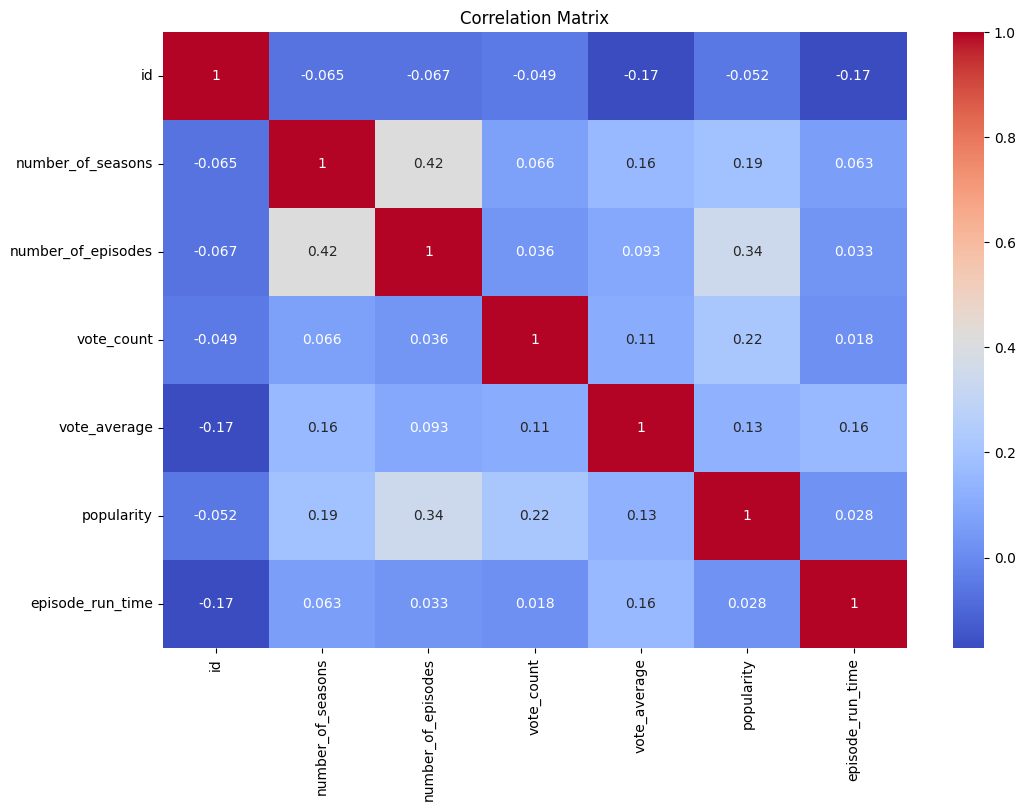

In [372]:
'''
creating a corelation matrix with numeric data
'''
numeric_data = df.select_dtypes(include='number')
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

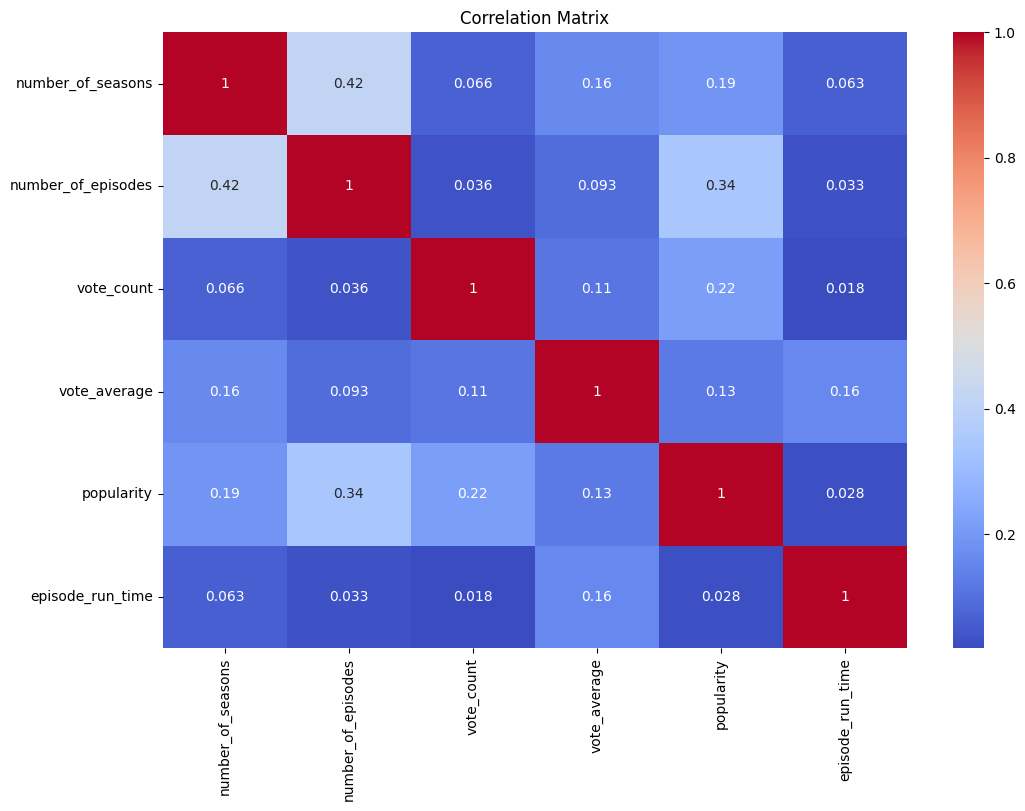

In [374]:
# Calculate the correlation matrix
numeric_data = df.select_dtypes(include='number').drop(columns=['id'], errors='ignore')
corr_matrix = numeric_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Correlation Matrix Insights
* 'number_of_seasons' and 'number_of_episodes' have a correlation of 0.42. This shows us that we have a moderately positive correlation, which makes sense since a show with more seasons tends to have more episodes
* 'vote_count' and 'popularity' have a correlation of 0.22, which is a weak positive correlation. This means that shows with more votes are slighly more popular, but it is not a strong relationship
* 'number_of_episodes' and 'popularity' have a correlation of 0.34, which is a moderatly positive correlation. This means that shows with more episodes tend to be more popular
* 'vote_average' and 'episode_run_time' have a correlation of 0.16, which is a weak positive corelation. This could mean that longer-running episodes might have a slightly higher average rating

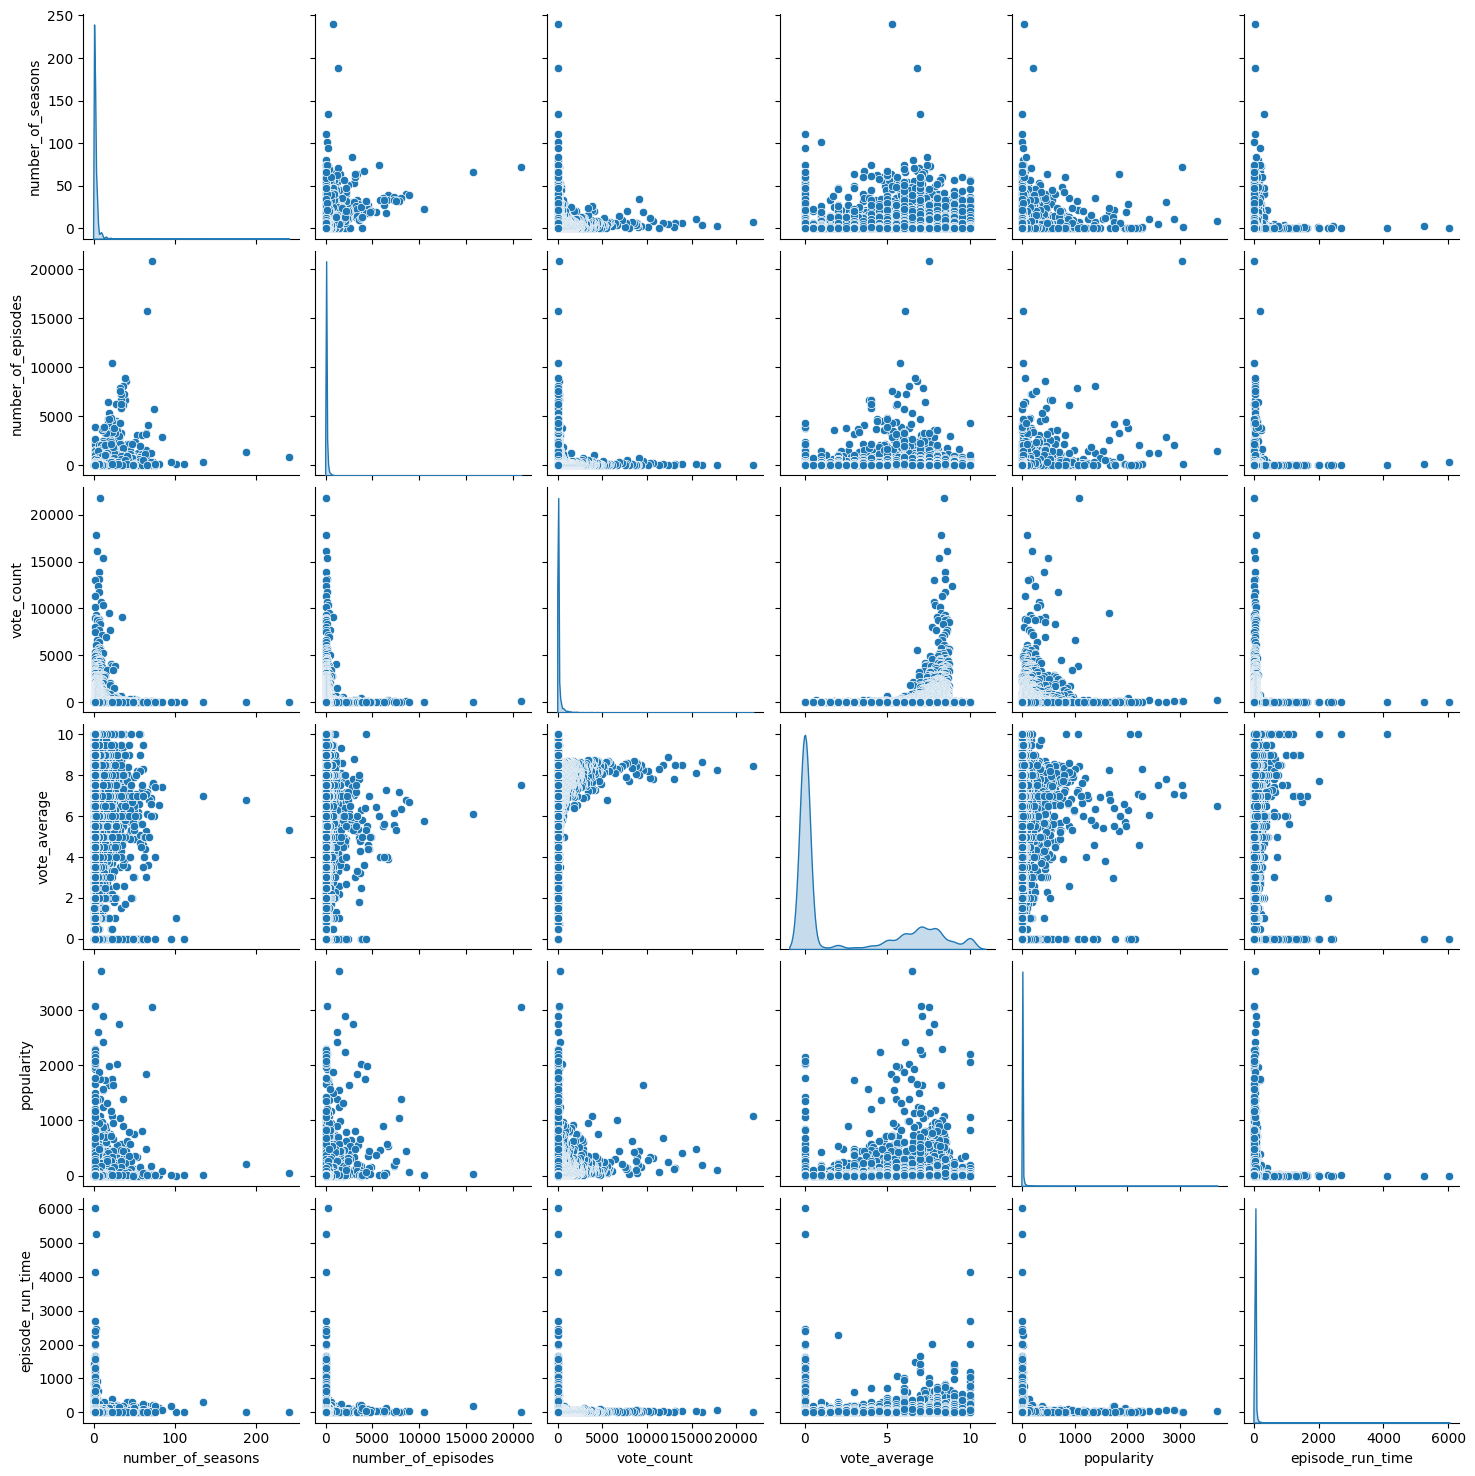

In [268]:
'''
creating a pair plot to examine the pairwise relationships between multiple features
'''
sns.pairplot(df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']], diag_kind='kde')
plt.show()

### Pair Plot Insights
* The scatter plots off the diagonal represent a relationship between two variables, while the diagonal plots show the distribution of a single varaible
* 'number_of_seasons' and 'number_of_episodes' have more of a linear relationship since shows with more seasons mostly have more episodes
* there are many distributions (like 'number_of_seasons' and 'vote_count') that are heavily skewed, with a large number of shows having a low count and only a few having very high values
* outliers are visible, like 'number_of_episodes' vs. 'vote_count' has some shows with a significantly high vote count compared to others

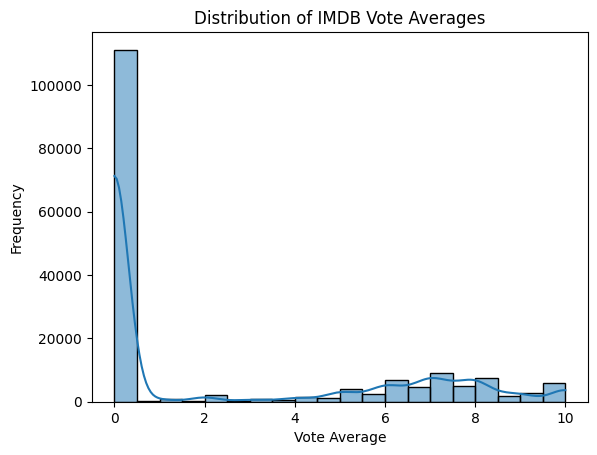

In [269]:
'''
histogram and KDE for vote_agerage
'''
sns.histplot(df['vote_average'], kde=True, bins=20)
plt.title('Distribution of IMDB Vote Averages')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()

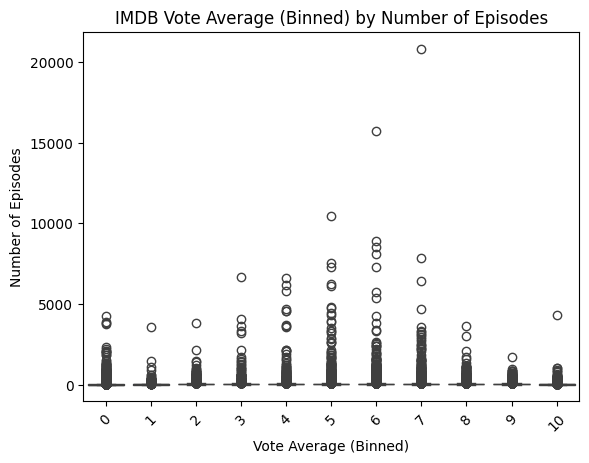

In [270]:
'''
boxplot to compare vote_average by number_of_episodes by first creating bins for the vote_average
'''

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # modify bins to include 10
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # 12 edges, include a bin for values 10-11

df['vote_average_binned'] = pd.cut(df['vote_average'], bins=bins, labels=labels, right=False)

sns.boxplot(x='vote_average_binned', y='number_of_episodes', data=df)
plt.title('IMDB Vote Average (Binned) by Number of Episodes')
plt.xticks(rotation=45)
plt.xlabel('Vote Average (Binned)')
plt.ylabel('Number of Episodes')
plt.show()

## Visualizing Distributions (Histograms)

In [271]:
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

In [272]:
df[numerical_columns].describe()

,number_of_seasons,number_of_episodes,vote_count,vote_average,popularity,episode_run_time
count,168639.000000,168639.000000,168639.000000,168639.000000,168639.000000,168639.000000
mean,1.548497,24.465082,13.305054,2.333843,5.882644,22.603348
std,2.942872,134.799622,190.809059,3.454334,42.023216,47.950427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.600000,0.000000
50%,1.000000,6.000000,0.000000,0.000000,0.857000,0.000000
75%,1.000000,20.000000,1.000000,6.000000,2.431500,42.000000
max,240.000000,20839.000000,21857.000000,10.000000,3707.008000,6032.000000


In [273]:
"""
# Regular Histograms

df[numerical_columns].hist(figsize=(12, 10), bins=15)
plt.suptitle('Histograms of Numerical Columns')
plt.show()
"""

"\n# Regular Histograms\n\ndf[numerical_columns].hist(figsize=(12, 10), bins=15)\nplt.suptitle('Histograms of Numerical Columns')\nplt.show()\n"

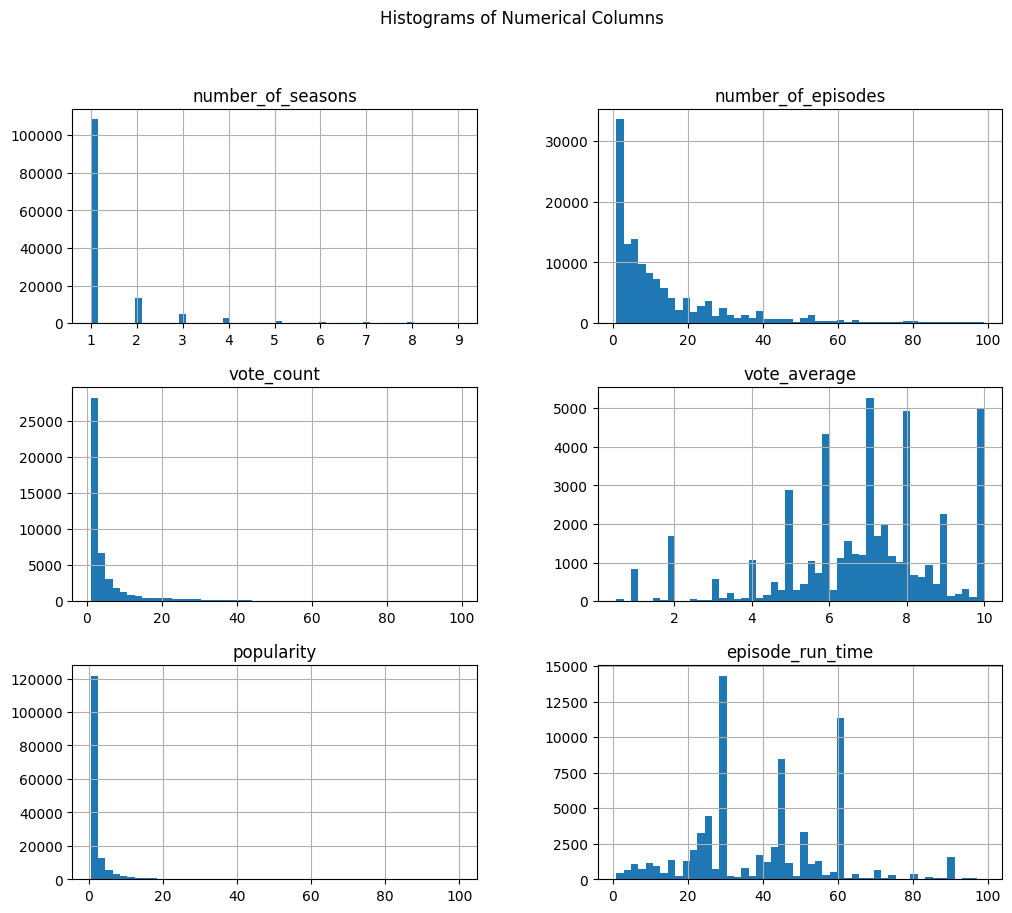

In [377]:
# Filter the DataFrame so it is easier to visualize without outliers
filtered_df = df[
    (df['number_of_seasons'] < 10) &
    (df['number_of_episodes'] < 100) &
    (df['vote_count'] < 100) &
    (df['popularity'] < 100) &
    (df['episode_run_time'] < 100)
]

# Replace 0 values with NaN in the filtered DataFrame to avoid skewing the plots
filtered_df = filtered_df.replace(0, np.nan)

# Plotting the histograms for the filtered data
filtered_df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']].hist(
    figsize=(12, 10), bins=50)

plt.suptitle('Histograms of Numerical Columns')
plt.show()


### Histogram Insights

- The histograms indicate that most of the numerical columns in the dataset have highly skewed distributions. (i.e, 'number_of_seasons' and 'number_of_episodes'  are clearly right-skewed)

- A small number of extreme values dominate the range indicating that outliers are present.

- We must deal with this to improve our models, so we should do log transformation and look at the outliers to see if we should discard them.

- **Feature Engineering Suggestions**: Log Transformation of numerical columns to potentially aid in skewness

- **Pre-processing Suggestions**: Outlier Analysis to improve predictive performance

## Distribution of TV-Shows without Zeroes + Understanding Amount of Zeross in Dataset

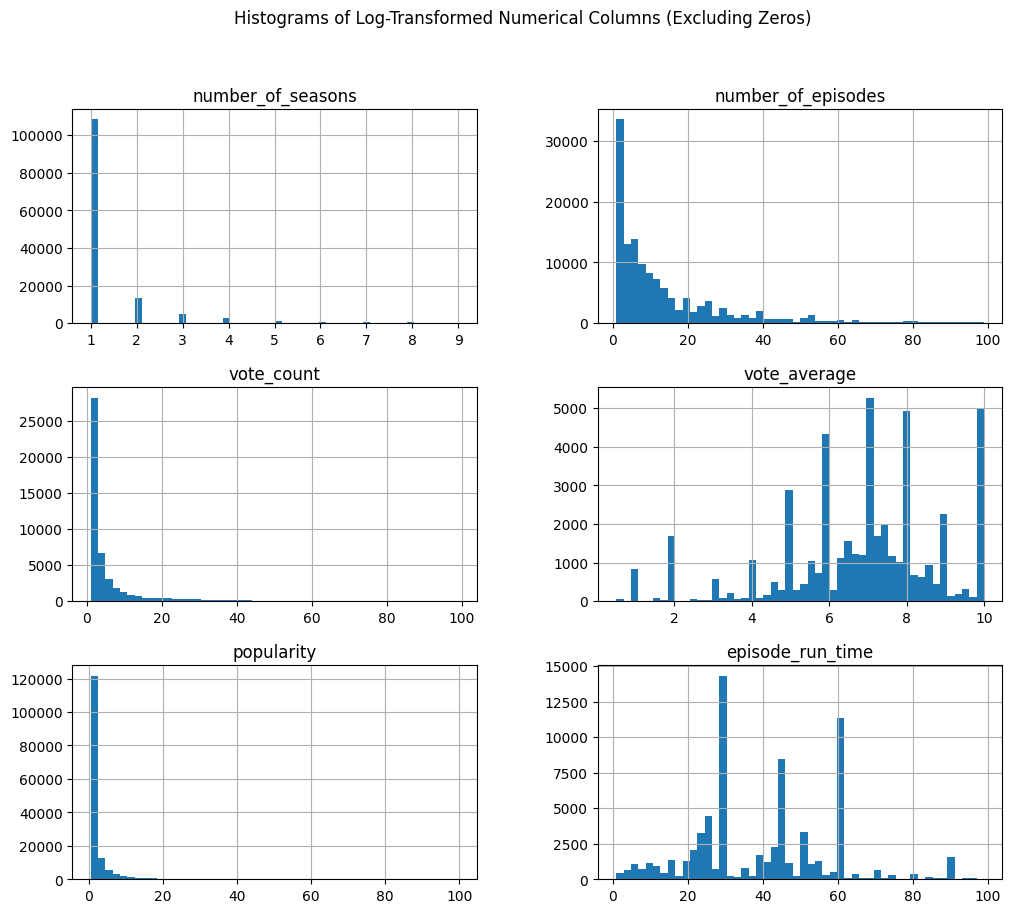

In [275]:
# Replace zeros with NaN to exclude them temporarily
df_nonzero = filtered_df[numerical_columns].replace(0, np.nan)
df_nonzero.hist(figsize=(12, 10), bins=50)
plt.suptitle('Histograms of Log-Transformed Numerical Columns (Excluding Zeros)')
plt.show()

In [276]:
threshold = 0.001

near_zero_counts = {}

for col in numerical_columns:
    count_near_zero = df[df[col] <= threshold].shape[0]
    percentage_near_zero = (count_near_zero / df.shape[0]) * 100
    near_zero_counts[col] = {'count': count_near_zero, 'percentage': percentage_near_zero}

near_zero_df = pd.DataFrame.from_dict(near_zero_counts, orient='index')
near_zero_df.columns = ['Count Near Zero (below 0.001)', 'Percentage Near Zero']

print(near_zero_df)

                    Count Near Zero (below 0.001)  Percentage Near Zero
number_of_seasons                           22428             13.299415
number_of_episodes                          24016             14.241071
vote_count                                 111137             65.902312
vote_average                               111135             65.901126
popularity                                   2385              1.414264
episode_run_time                            85315             50.590314


## Outlier Analysis (Using Interquartile Method)

In [277]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as points below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outliers = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR)))

# Number of outliers in each column
outliers_count = outliers.sum()
print("Number of Outliers in each column: \n", outliers_count)

Number of Outliers in each column: 
 number_of_seasons     54613
number_of_episodes    16793
vote_count            26221
vote_average              0
popularity            24368
episode_run_time       2868
dtype: int64


- Suggestions: Winsorize outliers after log transformation

# Data Preprocessing

### Handle Missing Values  

In [278]:
# Inspect the structure of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168639 entries, 0 to 168638
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    168639 non-null  int64   
 1   name                  168634 non-null  object  
 2   number_of_seasons     168639 non-null  int64   
 3   number_of_episodes    168639 non-null  int64   
 4   original_language     168639 non-null  object  
 5   vote_count            168639 non-null  int64   
 6   vote_average          168639 non-null  float64 
 7   overview              93333 non-null   object  
 8   adult                 168639 non-null  bool    
 9   backdrop_path         77780 non-null   object  
 10  first_air_date        136903 non-null  object  
 11  last_air_date         138735 non-null  object  
 12  homepage              50998 non-null   object  
 13  in_production         168639 non-null  bool    
 14  original_name         168634 non-nul

In [279]:
# Check for missing values
print(df.isnull().sum())

id                           0
name                         5
number_of_seasons            0
number_of_episodes           0
original_language            0
vote_count                   0
vote_average                 0
overview                 75306
adult                        0
backdrop_path            90859
first_air_date           31736
last_air_date            29904
homepage                117641
in_production                0
original_name                5
popularity                   0
poster_path              59902
type                         0
status                       0
tagline                 163309
genres                   68926
created_by              132143
languages                58589
networks                 71050
origin_country           31030
spoken_languages         59359
production_companies    109297
production_countries     91128
episode_run_time             0
vote_average_binned          0
dtype: int64


In [280]:
# Verify the data types of all columns
print(df.dtypes)

id                         int64
name                      object
number_of_seasons          int64
number_of_episodes         int64
original_language         object
vote_count                 int64
vote_average             float64
overview                  object
adult                       bool
backdrop_path             object
first_air_date            object
last_air_date             object
homepage                  object
in_production               bool
original_name             object
popularity               float64
poster_path               object
type                      object
status                    object
tagline                   object
genres                    object
created_by                object
languages                 object
networks                  object
origin_country            object
spoken_languages          object
production_companies      object
production_countries      object
episode_run_time           int64
vote_average_binned     category
dtype: obj

In [281]:
# Fill missing values for numerical columns with mean
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

In [282]:
'''
the changes I made here are that I filter out the 'object' data types and then check to see if it is not the
'genres' column. if it is not, then I add it to the 'columns_to_fill" list. this is because I am labeling
shows without a genre as 'Unknown' in the one-hot encoding step. then after that, I apply the mode of the
specific column to the missing value for now.
'''

categorical_cols = df.select_dtypes(include=['object']).columns
columns_to_fill = [col for col in categorical_cols if col != 'genres']
df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna(col.mode()[0]))

In [283]:
# Verify that there are no missing values
print(df.isnull().sum())

id                          0
name                        0
number_of_seasons           0
number_of_episodes          0
original_language           0
vote_count                  0
vote_average                0
overview                    0
adult                       0
backdrop_path               0
first_air_date              0
last_air_date               0
homepage                    0
in_production               0
original_name               0
popularity                  0
poster_path                 0
type                        0
status                      0
tagline                     0
genres                  68926
created_by                  0
languages                   0
networks                    0
origin_country              0
spoken_languages            0
production_companies        0
production_countries        0
episode_run_time            0
vote_average_binned         0
dtype: int64


### Remove Duplicates  

1,580 rows of data were removed due to it being a duplicate row.

In [284]:
# Check how many duplicates are there
num_duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicate_rows}")

Number of duplicate rows: 1580


In [285]:
# Remove duplicates
df = df.drop_duplicates()

In [286]:
num_duplicates_after = df.duplicated().sum()
print(f"Number of duplicates after removing: {num_duplicates_after}")

Number of duplicates after removing: 0


### Clean Text Data

In [287]:
'''
I made some notes on how to get nltk to work on your enviroment, I know that this has worked on VS Code
on macOS so if that is the enviroment and OS that you are using this should work. I hope it helps!

how to install nltk:
1. make sure you are working in a virtual enviroment when working on vs code, also
ensure you have python installed with the following command:
python --version

2. on macos, run this command to create the virtual enviroment:
python3 -m venv myenv

3. then activate the virtual enviroment with this command:
source myenv/bin/activate

4. then you can install packages like nltk with this command:
pip install nltk

5. once you have done this, check to see if nltk have been dowloaded with this command:
pip list
nltk should show up in the list

6. then in the terminal type in 'python3', then 'import nltk', then nltk.__version__, this will help
ensure that nltk is installed

7. then I ensured I have actually activated the virtual enviroment with this command, this
will be different depending on which directory your enviroment is located:
source /Users/safiaboutaleb/Developer/directv_tvrec/myenv/bin/activate

8. then I tried to reinstall the certificates with this command for nltk to finally work:
/Applications/Python\ 3.11/Install\ Certificates.command

The following lines of code below here are needed to install the nessesary components of nltk,
once you run this once, you can delete these lines of code because they will have already been installed:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

yt video that helped a bit:
https://www.youtube.com/watch?v=85Xr0UGR8qQ
'''

<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/var/folders/n4/c3jxqdvx2l15c7ghrhjmd95m0000gn/T/ipykernel_65306/281192106.py:1: SyntaxWarning: invalid escape sequence '\ '
  '''


"\nI made some notes on how to get nltk to work on your enviroment, I know that this has worked on VS Code\non macOS so if that is the enviroment and OS that you are using this should work. I hope it helps!\n\nhow to install nltk:\n1. make sure you are working in a virtual enviroment when working on vs code, also\nensure you have python installed with the following command:\npython --version\n\n2. on macos, run this command to create the virtual enviroment:\npython3 -m venv myenv\n\n3. then activate the virtual enviroment with this command:\nsource myenv/bin/activate\n\n4. then you can install packages like nltk with this command:\npip install nltk\n\n5. once you have done this, check to see if nltk have been dowloaded with this command:\npip list\nnltk should show up in the list\n\n6. then in the terminal type in 'python3', then 'import nltk', then nltk.__version__, this will help\nensure that nltk is installed\n\n7. then I ensured I have actually activated the virtual enviroment with

In [288]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathanvergonio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathanvergonio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathanvergonio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [289]:
'''
clean text function to convert text to lowercase, remove special characters
(punctuation, numbers, etc.), remove stop words, tokenize, and apply lemmatization
'''

def clean_text(text):
  text = text.lower()

  text = re.sub(r'[^a-zA-Z\s]', '', text)

  tokens = word_tokenize(text)

  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  cleaned_text = ' '.join(tokens)

  return cleaned_text

In [290]:
'''
now we use the clean_text function on the overview column
'''
df['cleaned_overview'] = df['overview'].apply(lambda x: clean_text(x) if pd.notnull(x) else '')

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/jonathanvergonio/nltk_data'
    - '/Users/jonathanvergonio/Documents/GitHub/directv_tvrec/env/nltk_data'
    - '/Users/jonathanvergonio/Documents/GitHub/directv_tvrec/env/share/nltk_data'
    - '/Users/jonathanvergonio/Documents/GitHub/directv_tvrec/env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
print(df['cleaned_overview'][0])
print(df['overview'][0])

KeyError: 'cleaned_overview'

In [ ]:
df = df.drop('overview', axis=1) # drop the original 'overview' column and save the chagnes to the csv file
df.to_csv('TMDB_tv_dataset_v3.csv', index=False)

### One-Hot Encoding of Categorical Features

* Genre One-Hot Encoding

In [291]:
'''
my plan here is to just split each genre as a token by using the comma as a delimiter, then find all
of the unique genres, and then one-hot encode them so I can drop the original genres column
'''

df['genres'] = df['genres'].fillna('Unknown') # for genres that are empty just call them Unknown

df['genres'] = df['genres'].apply(lambda x: x.split(', '))

unique_genres = sorted(set(genre for genres in df['genres'] for genre in genres))

for genre in unique_genres:
  df[genre] = df['genres'].apply(lambda genres: int(genre in genres))

df = df.drop('genres', axis=1)

In [292]:
# now here I can save the modifications to the csv file
df.to_csv('TMDB_tv_dataset_v3.csv', index=False)

* Rest of the One-Hot Encoding

In [293]:
# Creating a list of all columns with object values and inspecting their unique values
list = df.select_dtypes(include=['object']).columns.tolist()
print(df[list].nunique())

name                    155586
original_language          106
overview                 91243
backdrop_path            76300
first_air_date           18286
last_air_date            18705
homepage                 49758
original_name           157313
poster_path             106050
type                         7
status                       6
tagline                   5267
created_by               26081
languages                 1113
networks                  8196
origin_country             792
spoken_languages           946
production_companies     27132
production_countries      1247
dtype: int64


In [294]:
# Columns not included are name, overview, backdrop_path, homepage, original_name, poster_path, tagline, languages, spoken_languages,production_countries, and cleaned_overview
encode_cols =['original_language','type', 'status','created_by','networks','origin_country','production_companies']

In [295]:
# Creating a list of the top 20 values in the original_language column
top_20_original_language = df['original_language'].value_counts(ascending = False).head(20).index.tolist()
top_20_original_language

['en',
 'zh',
 'ja',
 'ko',
 'de',
 'fr',
 'es',
 'pt',
 'ru',
 'nl',
 'ar',
 'da',
 'cn',
 'th',
 'tr',
 'it',
 'hi',
 'sv',
 'cs',
 'no']

In [296]:
# Creating one-hot encoded columns for original_language
for i in top_20_original_language:
    name = 'original-language_' + i
    df[name] = np.where(df['original_language'] == i, 1, 0)

In [297]:
# Removing the original_language column from df and encode_cols
df.drop(columns = ['original_language'], inplace = True)
encode_cols.remove('original_language')
df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       'last_air_date', 'homepage', 'in_production', 'original_name',
       'popularity', 'poster_path', 'type', 'status', 'tagline', 'created_by',
       'languages', 'networks', 'origin_country', 'spoken_languages',
       'production_companies', 'production_countries', 'episode_run_time',
       'vote_average_binned', 'Action & Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'History', 'Kids', 'Music',
       'Musical', 'Mystery', 'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy',
       'Soap', 'Talk', 'Unknown', 'War & Politics', 'Western',
       'original-language_en', 'original-language_zh', 'original-language_ja',
       'original-language_ko', 'original-language_de', 'original-language_fr',
       'original-language_es', 'original-language_pt', 'original-language_ru',
       'original-

In [298]:
# Creating a list of the top 10 values in the created_by column
top_10_created_by = df['created_by'].value_counts(ascending = False).head(10).index.tolist()
top_10_created_by

['Shotaro Ishinomori',
 'John de Mol',
 'Adrián Suar',
 'Simon Fuller',
 'Ekta Kapoor',
 'Na Young-seok',
 'Yang Li-Hua',
 'Joseph Barbera, William Hanna',
 'R.J. Nuevas',
 'Mark Burnett']

In [299]:
# Creating one-hot encoded columns for created_by
for i in top_10_created_by:
    name = 'created-by_' + i
    df[name] = np.where(df['created_by'] == i, 1, 0)

In [300]:
# Removing the created_by column from df and encode_cols
df.drop(columns = ['created_by'], inplace = True)
encode_cols.remove('created_by')

df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       'last_air_date', 'homepage', 'in_production', 'original_name',
       'popularity', 'poster_path', 'type', 'status', 'tagline', 'languages',
       'networks', 'origin_country', 'spoken_languages',
       'production_companies', 'production_countries', 'episode_run_time',
       'vote_average_binned', 'Action & Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'History', 'Kids', 'Music',
       'Musical', 'Mystery', 'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy',
       'Soap', 'Talk', 'Unknown', 'War & Politics', 'Western',
       'original-language_en', 'original-language_zh', 'original-language_ja',
       'original-language_ko', 'original-language_de', 'original-language_fr',
       'original-language_es', 'original-language_pt', 'original-language_ru',
       'original-language_nl', 

In [301]:
# Creating a list of the top 11 values in the networks column
top_11_networks = df['networks'].value_counts(ascending = False).head(11).index.tolist()
top_11_networks

['BBC One',
 'YouTube',
 'Netflix',
 'ITV1',
 'BBC Two',
 'ABC',
 'NBC',
 'TVB Jade',
 'CBS',
 'Channel 4',
 'ZDF']

In [302]:
# Creating one-hot encoded columns for networks
for i in top_11_networks:
    name = 'networks_' + i
    df[name] = np.where(df['networks'] == i, 1, 0)

In [303]:
# Removing the networks column from df and encode_cols
df.drop(columns = ['networks'], inplace = True)
encode_cols.remove('networks')

df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       'last_air_date', 'homepage', 'in_production', 'original_name',
       'popularity', 'poster_path', 'type', 'status', 'tagline', 'languages',
       'origin_country', 'spoken_languages', 'production_companies',
       'production_countries', 'episode_run_time', 'vote_average_binned',
       'Action & Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 'Mystery',
       'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk',
       'Unknown', 'War & Politics', 'Western', 'original-language_en',
       'original-language_zh', 'original-language_ja', 'original-language_ko',
       'original-language_de', 'original-language_fr', 'original-language_es',
       'original-language_pt', 'original-language_ru', 'original-language_nl',
       'original-la

In [304]:
# Creating a list of the top 10 values in the origin_country column
top_26_origin_country = df['origin_country'].value_counts(ascending = False).head(26).index.tolist()
top_26_origin_country

['US',
 'JP',
 'GB',
 'CN',
 'DE',
 'KR',
 'CA',
 'FR',
 'AU',
 'BR',
 'NL',
 'RU',
 'ES',
 'TH',
 'HK',
 'IN',
 'DK',
 'PH',
 'IT',
 'TR',
 'SE',
 'NO',
 'TW',
 'BE',
 'CZ',
 'MX']

In [305]:
'''
I was getting a warning message when running the code due to performance issues, so I followed
the warnings sudgested approach to fix the issue by using the pd.concat function.
'''

one_hot_encoded_origin_country = pd.DataFrame() # start with an empty dataframe

for i in top_26_origin_country:
    one_hot_encoded_origin_country['origin-country_' + i] = np.where(df['origin_country'] == i, 1, 0)

# the we can concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, one_hot_encoded_origin_country], axis=1)

In [306]:
# Removing the origin_country column from df and encode_cols
df.drop(columns = ['origin_country'], inplace = True)
encode_cols.remove('origin_country')

df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'origin-country_DK', 'origin-country_PH', 'origin-country_IT',
       'origin-country_TR', 'origin-country_SE', 'origin-country_NO',
       'origin-country_TW', 'origin-country_BE', 'origin-country_CZ',
       'origin-country_MX'],
      dtype='object', length=113)

In [307]:
# Creating a list of the top 10 values in the production_companies column
top_10_production_companies = df['production_companies'].value_counts(ascending = False).head(10).index.tolist()
top_10_production_companies

['TVB',
 'BBC',
 'Estúdios Globo',
 'NHK',
 'DR TV',
 'TV 2',
 'Televisa',
 'GMA Entertainment Group',
 'Česká televize',
 'ATV Enterprises Limited']

In [308]:
'''
did the same changes to this code cell as well to fix the warning message
'''

one_hot_encoded_production_companies = pd.DataFrame() # start with an empty dataframe

for i in top_26_origin_country:
    one_hot_encoded_production_companies['production-companies_' + i] = np.where(df['production_companies'] == i, 1, 0)

# the we can concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, one_hot_encoded_production_companies], axis=1)

In [309]:
# Removing the production_companies column from df and encode_cols
df.drop(columns = ['production_companies'], inplace = True)
encode_cols.remove('production_companies')

df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'production-companies_DK', 'production-companies_PH',
       'production-companies_IT', 'production-companies_TR',
       'production-companies_SE', 'production-companies_NO',
       'production-companies_TW', 'production-companies_BE',
       'production-companies_CZ', 'production-companies_MX'],
      dtype='object', length=138)

In [310]:
# One-hot encoding remaining columns
for colname in encode_cols:
    df_encoded = pd.get_dummies(df[colname], prefix=colname+'')
    df = df.join(df_encoded)

df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'type_Reality', 'type_Scripted', 'type_Talk Show', 'type_Video',
       'status_Canceled', 'status_Ended', 'status_In Production',
       'status_Pilot', 'status_Planned', 'status_Returning Series'],
      dtype='object', length=151)

In [311]:
# Removing remaining original cols from df
df.drop(columns=encode_cols,axis=1,inplace=True)

df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'type_Reality', 'type_Scripted', 'type_Talk Show', 'type_Video',
       'status_Canceled', 'status_Ended', 'status_In Production',
       'status_Pilot', 'status_Planned', 'status_Returning Series'],
      dtype='object', length=149)

In [312]:
df.head(10)

,id,name,number_of_seasons,number_of_episodes,vote_count,vote_average,overview,adult,backdrop_path,first_air_date,last_air_date,homepage,in_production,original_name,popularity,poster_path,tagline,languages,spoken_languages,production_countries,episode_run_time,vote_average_binned,Action & Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,History,Kids,Music,Musical,Mystery,News,Reality,Romance,Sci-Fi & Fantasy,Soap,Talk,Unknown,War & Politics,Western,original-language_en,original-language_zh,original-language_ja,original-language_ko,original-language_de,original-language_fr,original-language_es,original-language_pt,original-language_ru,original-language_nl,original-language_ar,original-language_da,original-language_cn,original-language_th,original-language_tr,original-language_it,original-language_hi,original-language_sv,original-language_cs,original-language_no,created-by_Shotaro Ishinomori,created-by_John de Mol,created-by_Adrián Suar,created-by_Simon Fuller,created-by_Ekta Kapoor,created-by_Na Young-seok,created-by_Yang Li-Hua,"created-by_Joseph Barbera, William Hanna",created-by_R.J. Nuevas,created-by_Mark Burnett,networks_BBC One,networks_YouTube,networks_Netflix,networks_ITV1,networks_BBC Two,networks_ABC,networks_NBC,networks_TVB Jade,networks_CBS,networks_Channel 4,networks_ZDF,origin-country_US,origin-country_JP,origin-country_GB,origin-country_CN,origin-country_DE,origin-country_KR,origin-country_CA,origin-country_FR,origin-country_AU,origin-country_BR,origin-country_NL,origin-country_RU,origin-country_ES,origin-country_TH,origin-country_HK,origin-country_IN,origin-country_DK,origin-country_PH,origin-country_IT,origin-country_TR,origin-country_SE,origin-country_NO,origin-country_TW,origin-country_BE,origin-country_CZ,origin-country_MX,production-companies_US,production-companies_JP,production-companies_GB,production-companies_CN,production-companies_DE,production-companies_KR,production-companies_CA,production-companies_FR,production-companies_AU,production-companies_BR,production-companies_NL,production-companies_RU,production-companies_ES,production-companies_TH,production-companies_HK,production-companies_IN,production-companies_DK,production-companies_PH,production-companies_IT,production-companies_TR,production-companies_SE,production-companies_NO,production-companies_TW,production-companies_BE,production-companies_CZ,production-companies_MX,type_Documentary,type_Miniseries,type_News,type_Reality,type_Scripted,type_Talk Show,type_Video,status_Canceled,status_Ended,status_In Production,status_Pilot,status_Planned,status_Returning Series
0,1399.0,Game of Thrones,8.0,73.0,21857.0,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,2019-05-19,http://www.hbo.com/game-of-thrones,False,Game of Thrones,1083.917,/1XS1oqL89opfnbLl8WnZY1O1uJx.jpg,Winter Is Coming,en,English,"United Kingdom, United States of America",0.0,8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,False,False,True,False,False,False,False
1,71446.0,Money Heist,3.0,41.0,17836.0,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,2021-12-03,https://www.netflix.com/title/80192098,False,La Casa de Papel,96.354,/reEMJA1uzscCbkpeRJeTT2bjqUp.jpg,The perfect robbery.,es,Español,Spain,70.0,8,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [313]:
# Converting first_air_date and last_air_date columns to DateTime referring to https://www.youtube.com/watch?v=f7LODKIjtaA
df['first_air_date'] = pd.to_datetime(df['first_air_date'], format = '%Y-%m-%d')
df['last_air_date'] = pd.to_datetime(df['last_air_date'], format = '%Y-%m-%d' )
print(df['first_air_date'].dtypes)
print(df['last_air_date'].dtypes)

datetime64[ns]
datetime64[ns]


In [314]:
print(df['first_air_date'])

0        2011-04-17
1        2017-05-02
2        2016-07-15
3        2010-10-31
4        2016-01-25
            ...    
168412          NaT
168416          NaT
168418          NaT
168419          NaT
168420          NaT
Name: first_air_date, Length: 168593, dtype: datetime64[ns]


In [315]:
print(df['last_air_date'])

0        2019-05-19
1        2021-12-03
2        2022-07-01
3        2022-11-20
4        2021-09-10
            ...    
168412          NaT
168416          NaT
168418          NaT
168419          NaT
168420          NaT
Name: last_air_date, Length: 168593, dtype: datetime64[ns]


In [316]:
# Creating a function to create seasons for each month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'WINTER'
    elif month in [3, 4, 5]:
        return 'SPRING'
    elif month in [6, 7, 8]:
        return 'SUMMER'
    elif month in [9, 10, 11]:
        return 'FALL'
    else:
        return 'UNKNOWN'

In [317]:
# Creating a column with the seasons for first_air_date
df['first_air_date_season'] = df['first_air_date'].apply(get_season)
df['first_air_date_season']

0          SPRING
1          SPRING
2          SUMMER
3            FALL
4          WINTER
           ...   
168412    UNKNOWN
168416    UNKNOWN
168418    UNKNOWN
168419    UNKNOWN
168420    UNKNOWN
Name: first_air_date_season, Length: 168593, dtype: object

In [318]:
# Creating columns for first_air_date_season as boolean values
df['first_air_date_winter'] = df['first_air_date_season'] == 'WINTER'
df['first_air_date_spring'] = df['first_air_date_season'] == 'SPRING'
df['first_air_date_summer'] = df['first_air_date_season'] == 'SUMMER'
df['first_air_date_fall'] = df['first_air_date_season'] == 'FALL'

In [319]:
# Drop the first_air_date_season and first_air_date columns if necessary
# df.drop('first_air_date_season', axis = 1, inplace = True)
# df.drop('first_air_date', axis = 1, inplace = True)

In [320]:
# Repeating same process for last_air_date
df['last_air_date_season'] = df['last_air_date'].apply(get_season)
df['last_air_date_season']

0          SPRING
1          WINTER
2          SUMMER
3            FALL
4            FALL
           ...   
168412    UNKNOWN
168416    UNKNOWN
168418    UNKNOWN
168419    UNKNOWN
168420    UNKNOWN
Name: last_air_date_season, Length: 168593, dtype: object

In [321]:
df['last_air_date_winter'] = df['last_air_date_season'] == 'WINTER'
df['last_air_date_spring'] = df['last_air_date_season'] == 'SPRING'
df['last_air_date_summer'] = df['last_air_date_season'] == 'SUMMER'
df['last_air_date_fall'] = df['last_air_date_season'] == 'FALL'

In [322]:
# Drop the last_air_date_season and last_air_date columns if necessary
# df.drop('last_air_date_season', axis = 1, inplace = True)
# df.drop('last_air_date', axis = 1, inplace = True)

In [323]:
# Inspecting columns to ensure process was done correctly
df.head(5)

,id,name,number_of_seasons,number_of_episodes,vote_count,vote_average,overview,adult,backdrop_path,first_air_date,last_air_date,homepage,in_production,original_name,popularity,poster_path,tagline,languages,spoken_languages,production_countries,episode_run_time,vote_average_binned,Action & Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,History,Kids,Music,Musical,Mystery,News,Reality,Romance,Sci-Fi & Fantasy,Soap,Talk,Unknown,War & Politics,Western,original-language_en,original-language_zh,original-language_ja,original-language_ko,original-language_de,original-language_fr,original-language_es,original-language_pt,original-language_ru,original-language_nl,original-language_ar,original-language_da,original-language_cn,original-language_th,original-language_tr,original-language_it,original-language_hi,original-language_sv,original-language_cs,original-language_no,created-by_Shotaro Ishinomori,created-by_John de Mol,created-by_Adrián Suar,created-by_Simon Fuller,created-by_Ekta Kapoor,created-by_Na Young-seok,created-by_Yang Li-Hua,"created-by_Joseph Barbera, William Hanna",created-by_R.J. Nuevas,created-by_Mark Burnett,networks_BBC One,networks_YouTube,networks_Netflix,networks_ITV1,networks_BBC Two,networks_ABC,networks_NBC,networks_TVB Jade,networks_CBS,networks_Channel 4,networks_ZDF,origin-country_US,origin-country_JP,origin-country_GB,origin-country_CN,origin-country_DE,origin-country_KR,origin-country_CA,origin-country_FR,origin-country_AU,origin-country_BR,origin-country_NL,origin-country_RU,origin-country_ES,origin-country_TH,origin-country_HK,origin-country_IN,origin-country_DK,origin-country_PH,origin-country_IT,origin-country_TR,origin-country_SE,origin-country_NO,origin-country_TW,origin-country_BE,origin-country_CZ,origin-country_MX,production-companies_US,production-companies_JP,production-companies_GB,production-companies_CN,production-companies_DE,production-companies_KR,production-companies_CA,production-companies_FR,production-companies_AU,production-companies_BR,production-companies_NL,production-companies_RU,production-companies_ES,production-companies_TH,production-companies_HK,production-companies_IN,production-companies_DK,production-companies_PH,production-companies_IT,production-companies_TR,production-companies_SE,production-companies_NO,production-companies_TW,production-companies_BE,production-companies_CZ,production-companies_MX,type_Documentary,type_Miniseries,type_News,type_Reality,type_Scripted,type_Talk Show,type_Video,status_Canceled,status_Ended,status_In Production,status_Pilot,status_Planned,status_Returning Series,first_air_date_season,first_air_date_winter,first_air_date_spring,first_air_date_summer,first_air_date_fall,last_air_date_season,last_air_date_winter,last_air_date_spring,last_air_date_summer,last_air_date_fall
0,1399.0,Game of Thrones,8.0,73.0,21857.0,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,2019-05-19,http://www.hbo.com/game-of-thrones,False,Game of Thrones,1083.917,/1XS1oqL89opfnbLl8WnZY1O1uJx.jpg,Winter Is Coming,en,English,"United Kingdom, United States of America",0.0,8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,False,False,True,False,False,False,False,SPRING,False,True,False,False,SPRING,False,True,False,False
1,71446.0,Money Heist,3.0,41.0,17836.0,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,2021-12-03,https://www.netflix.com/title/80192098,False,La Casa de Papel,96.354,/reEMJA1uzscCbkpeRJeTT2bjqUp.jpg

## Log Transformation

In [378]:
# List of original numerical columns
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

# Apply log transformation and rename columns with "_log"
df_log = df[numerical_columns].apply(lambda x: np.log1p(x)).add_suffix('_log')

# Concatenate the log-transformed columns with the original DataFrame
df = pd.concat([df, df_log], axis=1)

# Display the DataFrame to confirm new columns
print(df.head())

      id              name  number_of_seasons  number_of_episodes  \
0   1399   Game of Thrones                  8                  73   
1  71446       Money Heist                  3                  41   
2  66732   Stranger Things                  4                  34   
3   1402  The Walking Dead                 11                 177   
4  63174           Lucifer                  6                  93   

  original_language  vote_count  vote_average  \
0                en       21857         8.442   
1                es       17836         8.257   
2                en       16161         8.624   
3                en       15432         8.121   
4                en       13870         8.486   

                                            overview  adult  \
0  Seven noble families fight for control of the ...  False   
1  To carry out the biggest heist in history, a m...  False   
2  When a young boy vanishes, a small town uncove...  False   
3  Sheriff's deputy Rick Grimes awaken

In [379]:
numerical_columns_log = ['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 'vote_average_log', 'popularity_log', 'episode_run_time_log']
df[numerical_columns_log].describe()

,number_of_seasons_log,number_of_episodes_log,vote_count_log,vote_average_log,popularity_log,episode_run_time_log
count,168639.000000,168639.000000,168639.000000,168639.000000,168639.000000,168639.000000
mean,0.756919,2.009143,0.570469,0.686665,1.025423,1.794548
std,0.493878,1.430825,1.118709,0.974438,0.893007,1.871854
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.693147,0.693147,0.000000,0.000000,0.470004,0.000000
50%,0.693147,1.945910,0.000000,0.000000,0.618962,0.000000
75%,0.693147,3.044522,0.693147,1.945910,1.232997,3.761200
max,5.484797,9.944629,9.992322,2.397895,8.218250,8.705000


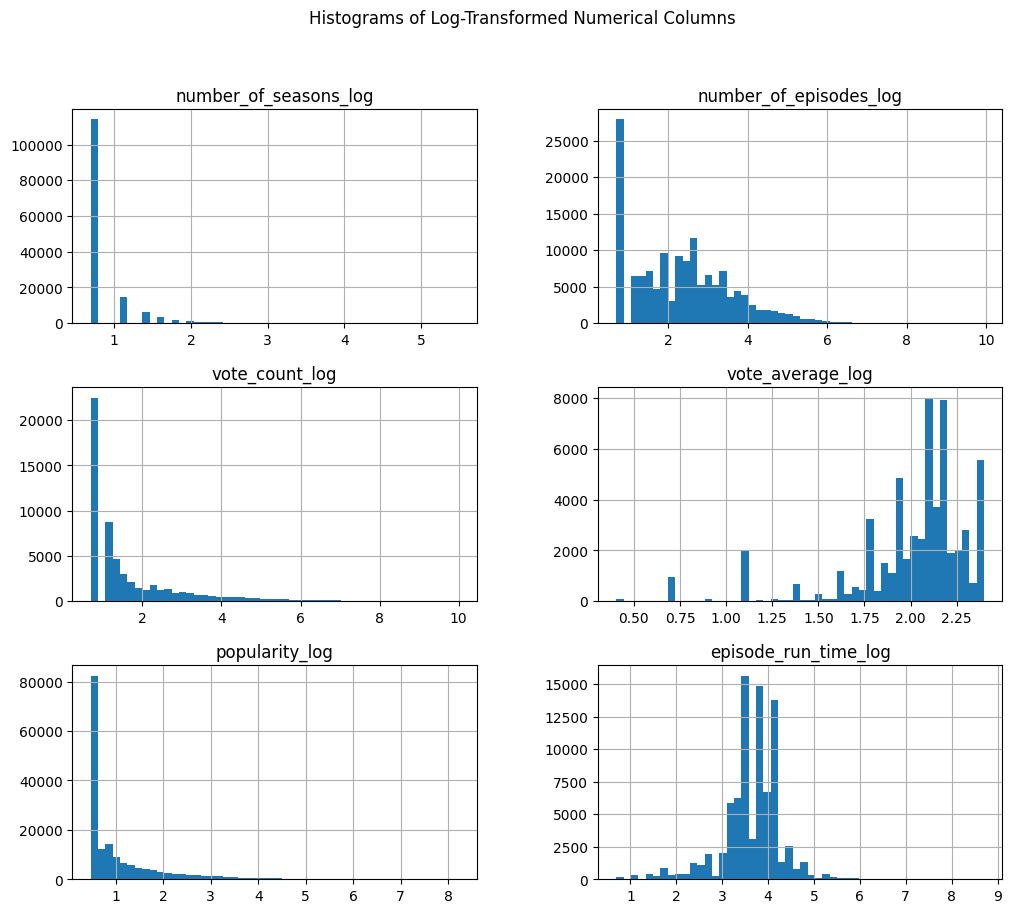

In [390]:
# Plotting histograms after log transformation
df_log.replace(0, np.nan).hist(figsize=(12, 10), bins=50)
plt.suptitle('Histograms of Log-Transformed Numerical Columns')
plt.show()


- A log transformation is a mathematical operation applied to data where each data point is replaced by its logarithm (typically base 10 or natural log).

- This transformation is particularly useful when dealing with data that spans several orders of magnitude or when the data distribution is highly skewed.

- By applying a log transformation, large values are compressed, and small values are spread out, leading to a more symmetrical (or normal) distribution.

- This can make patterns in the data more apparent and improve the performance of statistical models, especially those that assume normality or homoscedasticity (constant variance).

- Log transformation is often necessary when dealing with positively skewed data, as it stabilizes variance and reduces the impact of outliers, making the data more suitable for analysis.

In [327]:
# KDE plot for a specific column
"""
for column in df_log.columns:
    sns.kdeplot(df[column], shade=True)
    plt.title(f'KDE Plot for {column}')
    plt.show()
"""

"\nfor column in df_log.columns:\n    sns.kdeplot(df[column], shade=True)\n    plt.title(f'KDE Plot for {column}')\n    plt.show()\n"

In [328]:
"""
# KDE plot for a specific column
for column in df_log.columns:
    sns.kdeplot(df_log[column], shade=True)
    plt.title(f'KDE Plot for {column}')
    plt.show()
"""

"\n# KDE plot for a specific column\nfor column in df_log.columns:\n    sns.kdeplot(df_log[column], shade=True)\n    plt.title(f'KDE Plot for {column}')\n    plt.show()\n"

### Outliers amount changed after Log transformation

In [391]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the original data
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define outliers in the original data as points below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outliers_original = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR)))

# Count the number of outliers in each column for the original data
outliers_count_original = outliers_original.sum()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the log-transformed data
Q1_log = df_log[numerical_columns_log].quantile(0.25)
Q3_log = df_log[numerical_columns_log].quantile(0.75)
IQR_log = Q3_log - Q1_log

# Define outliers in the log-transformed data
outliers_log = ((df_log[numerical_columns_log] < (Q1_log - 1.5 * IQR_log)) | (df_log[numerical_columns_log] > (Q3_log + 1.5 * IQR_log)))

# Count the number of outliers in each column for the log-transformed data
outliers_count_log = outliers_log.sum()

# Calculate the decrease in the number of outliers
outliers_decrease = outliers_count_original - outliers_count_log

# Display the results
print("Number of Outliers in each column (Non-Log Transformed):\n", outliers_count_original)
print("\nNumber of Outliers in each column (Log-Transformed):\n", outliers_count_log)
print("\nDecrease in the number of outliers after log transformation:\n", outliers_decrease)


Number of Outliers in each column (Non-Log Transformed):
 number_of_seasons     54613
number_of_episodes    16793
vote_count            26221
vote_average              0
popularity            24368
episode_run_time       2868
dtype: int64

Number of Outliers in each column (Log-Transformed):
 number_of_seasons_log     54613
number_of_episodes_log      378
vote_count_log            18585
vote_average_log              0
popularity_log            14897
episode_run_time_log          0
dtype: int64

Decrease in the number of outliers after log transformation:
 episode_run_time         NaN
episode_run_time_log     NaN
number_of_episodes       NaN
number_of_episodes_log   NaN
number_of_seasons        NaN
number_of_seasons_log    NaN
popularity               NaN
popularity_log           NaN
vote_average             NaN
vote_average_log         NaN
vote_count               NaN
vote_count_log           NaN
dtype: float64


### Boxplot + Scatterplot before and after Log Transformation

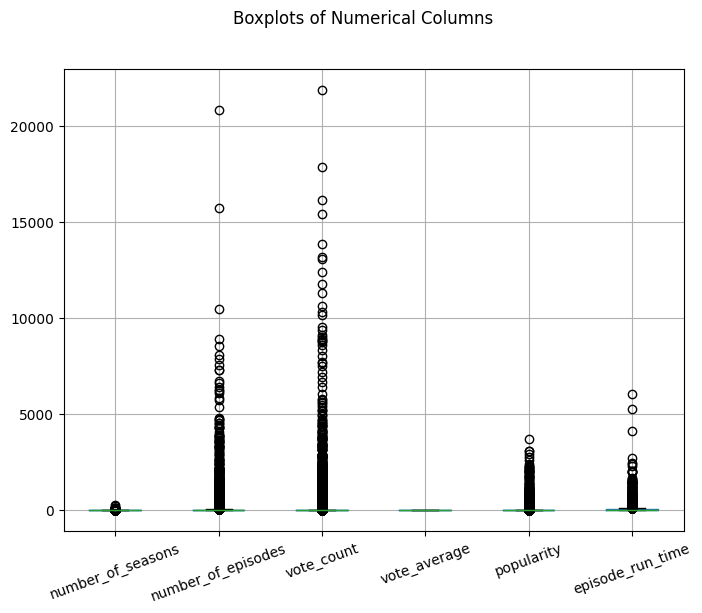

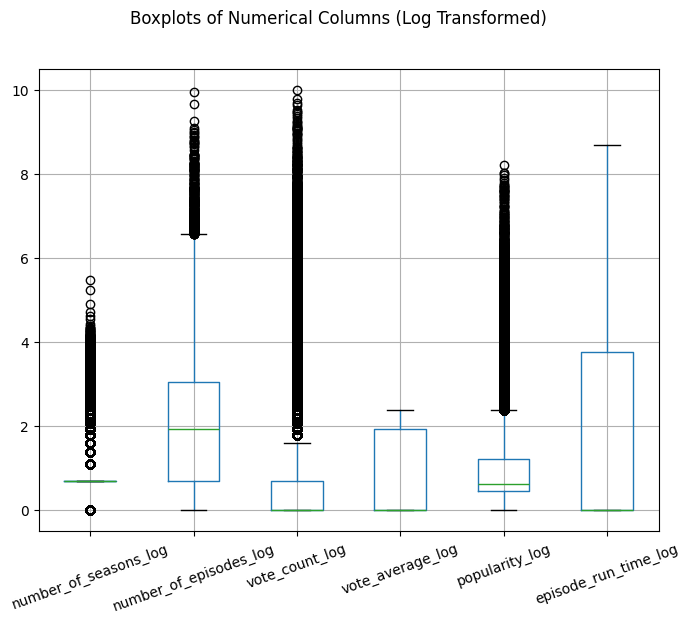

In [387]:
# Box plot for original numerical columns
df[numerical_columns].boxplot(figsize=(8, 6))
plt.suptitle('Boxplots of Numerical Columns')
plt.xticks(rotation=20)  # Rotate x-axis labels for better readability
plt.show()

# Box plot for log-transformed numerical columns
df[numerical_columns_log].boxplot(figsize=(8, 6))
plt.suptitle('Boxplots of Numerical Columns (Log Transformed)')
plt.xticks(rotation=20)  # Rotate x-axis labels for better readability
plt.show()

In [331]:
#I'm not sure what happened but we have to make sure there is no null values again, if we delete this there's a bug
# Fill missing values for numerical columns with mean
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

print(df[numerical_columns].isna().sum())

# Fill missing values for numerical columns with mean (Log Transformed)
df_log[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

print(df_log[numerical_columns].isna().sum())

number_of_seasons     0
number_of_episodes    0
vote_count            0
vote_average          0
popularity            0
episode_run_time      0
dtype: int64
number_of_seasons     0
number_of_episodes    0
vote_count            0
vote_average          0
popularity            0
episode_run_time      0
dtype: int64


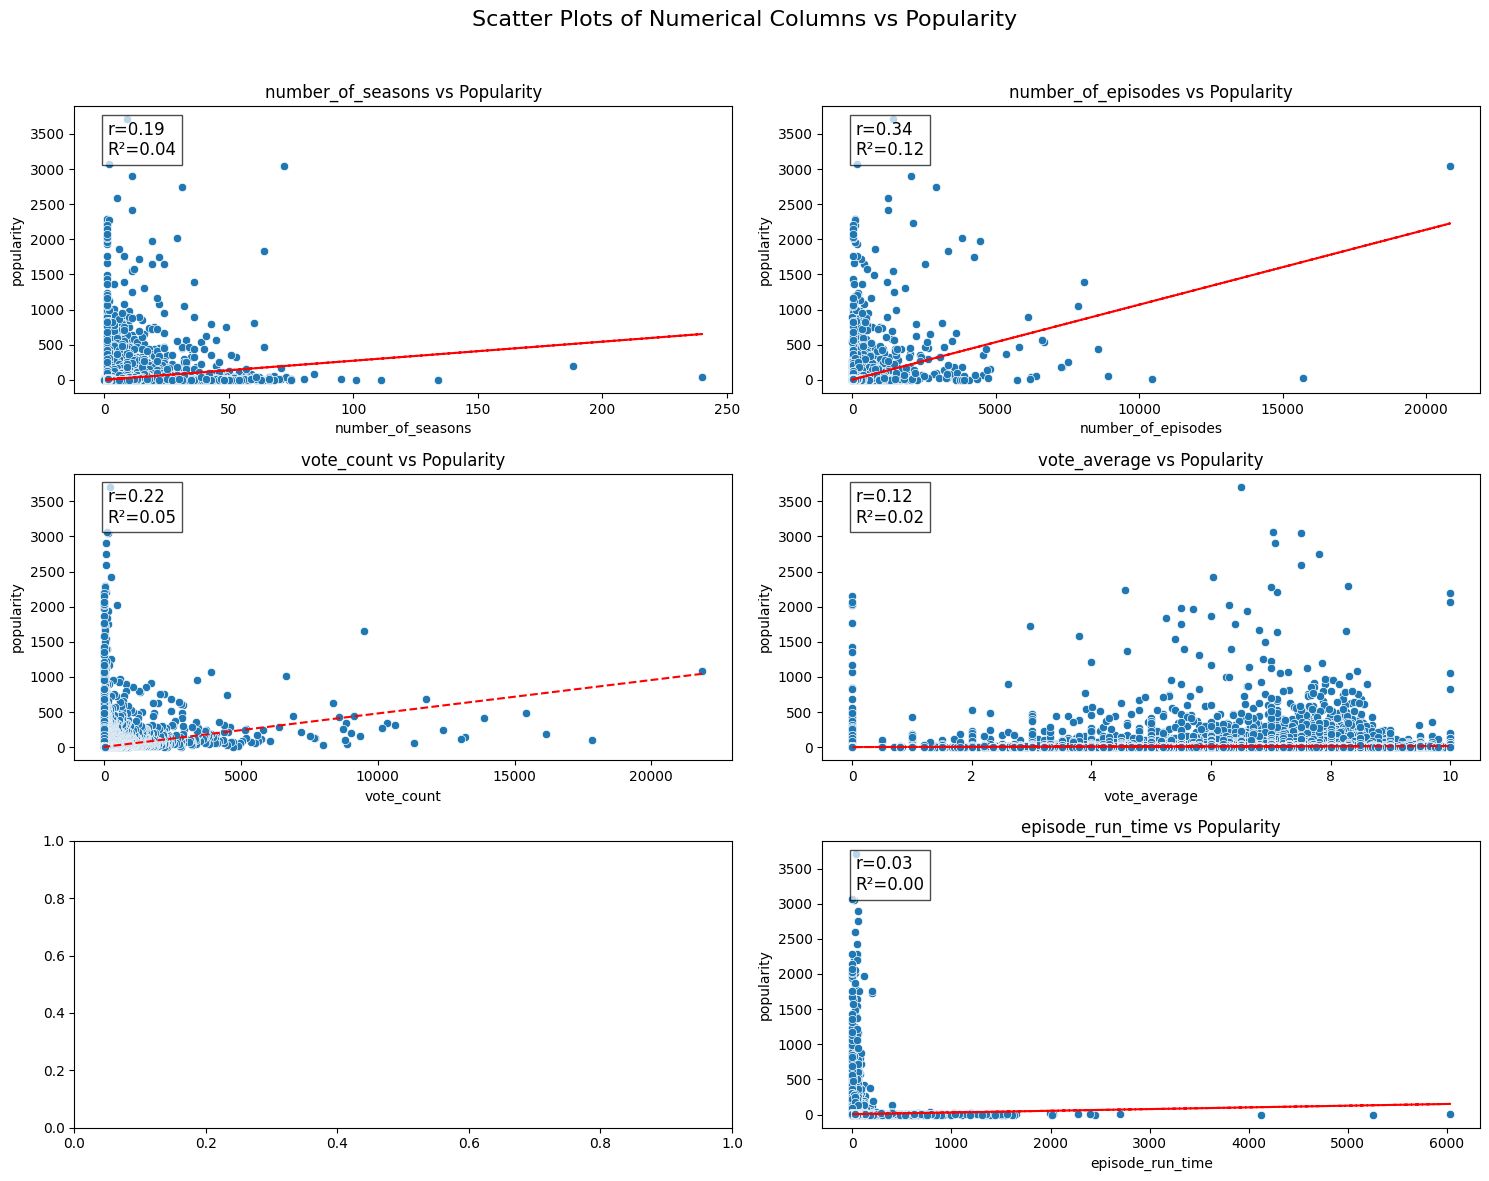

In [332]:
from sklearn.linear_model import LinearRegression

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 rows, 2 columns layout
fig.suptitle('Scatter Plots of Numerical Columns vs Popularity', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each scatter plot in a subplot
for i, col in enumerate(numerical_columns):
    if col != 'popularity':  # Skip 'popularity' as we are comparing against it
        # Calculate correlation coefficient
        corr_coef = np.corrcoef(df[col], df['popularity'])[0, 1]

        # Fit linear regression model
        X = df[col].values.reshape(-1, 1)
        y = df['popularity'].values
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        r_squared = model.score(X, y)

        # Plot scatter plot
        sns.scatterplot(x=df[col], y=df['popularity'], ax=axes[i])
        # Plot trend line
        axes[i].plot(df[col], y_pred, color='red', linestyle='--')

        # Annotate with correlation coefficient and R-squared
        axes[i].text(0.05, 0.95, f'r={corr_coef:.2f}\nR²={r_squared:.2f}',
                     transform=axes[i].transAxes, fontsize=12,
                     verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

        axes[i].set_title(f'{col} vs Popularity')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('popularity')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

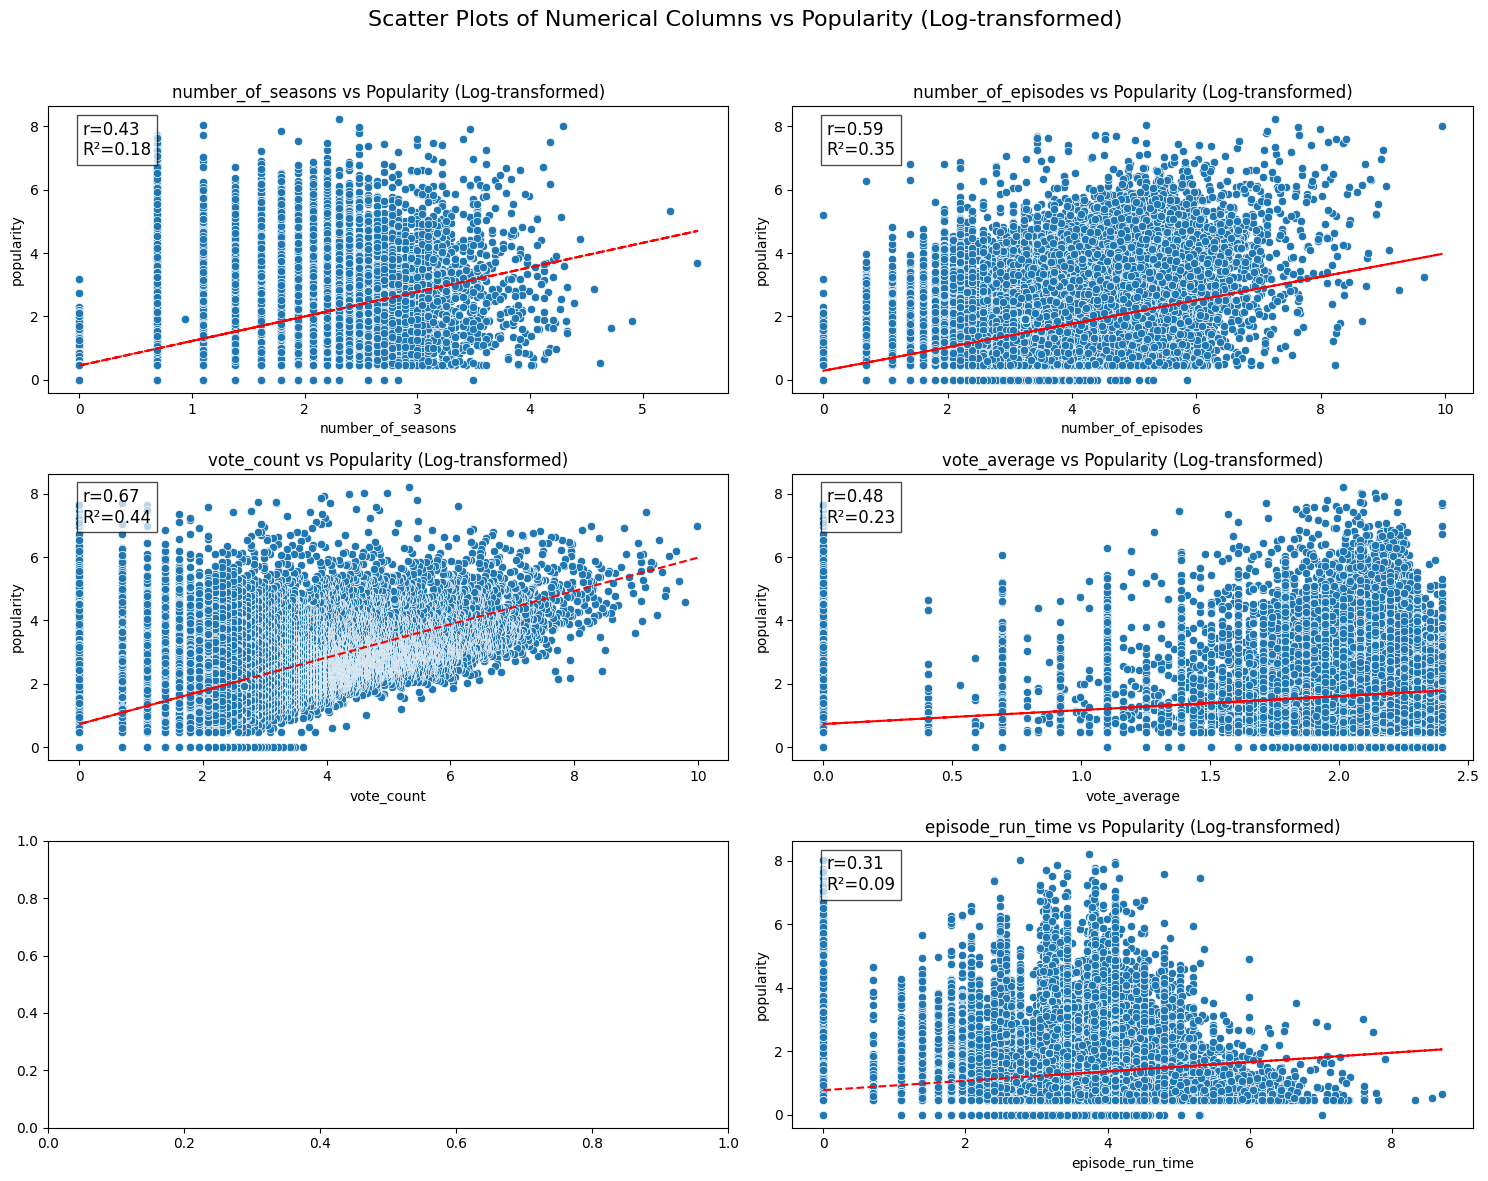

In [333]:
#LOG TRANSFORMED VALUES
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count',
                     'vote_average', 'popularity', 'episode_run_time']

df_log = df[numerical_columns].apply(lambda x: np.log1p(x))

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 rows, 2 columns layout
fig.suptitle('Scatter Plots of Numerical Columns vs Popularity (Log-transformed)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each scatter plot in a subplot
for i, col in enumerate(numerical_columns):
    if col != 'popularity':  # Skip 'popularity' as we are comparing against it
        # Calculate correlation coefficient
        corr_coef = np.corrcoef(df_log[col], df_log['popularity'])[0, 1]

        # Fit linear regression model
        X = df_log[col].values.reshape(-1, 1)
        y = df_log['popularity'].values
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        r_squared = model.score(X, y)

        # Plot scatter plot
        sns.scatterplot(x=df_log[col], y=df_log['popularity'], ax=axes[i])
        # Plot trend line
        axes[i].plot(df_log[col], y_pred, color='red', linestyle='--')

        # Annotate with correlation coefficient and R-squared
        axes[i].text(0.05, 0.95, f'r={corr_coef:.2f}\nR²={r_squared:.2f}',
                     transform=axes[i].transAxes, fontsize=12,
                     verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

        axes[i].set_title(f'{col} vs Popularity (Log-transformed)')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('popularity')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Winsorize Outliers (after Log transformation)

In [395]:
from scipy.stats.mstats import winsorize

# Define the limits for Winsorization
lower_limit = 0.05  # 5th percentile
upper_limit = 0.95  # 95th percentile

# Apply Winsorization to each numerical column
df = df[numerical_columns].apply(lambda x: winsorize(x, limits=(lower_limit, 1 - upper_limit)))

# Display the first few rows of the winsorized data
print(df.head())


   number_of_seasons  number_of_episodes  vote_count  vote_average  \
0                  4                  73          18         8.442   
1                  3                  41          18         8.257   
2                  4                  34          18         8.624   
3                  4                  91          18         8.121   
4                  4                  91          18         8.486   

   popularity  episode_run_time  
0      18.448                 0  
1      18.448                60  
2      18.448                 0  
3      18.448                42  
4      18.448                45  


In [396]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the original data
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define outliers in the original data as points below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outliers_original = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR)))

# Count the number of outliers in each column for the original data
outliers_count_original = outliers_original.sum()

# Display the results
print("Number of Outliers in each column (Non-Log Transformed):\n", outliers_count_original)

Number of Outliers in each column (Non-Log Transformed):
 number_of_seasons     54613
number_of_episodes    16793
vote_count            26221
vote_average              0
popularity            24368
episode_run_time          0
dtype: int64


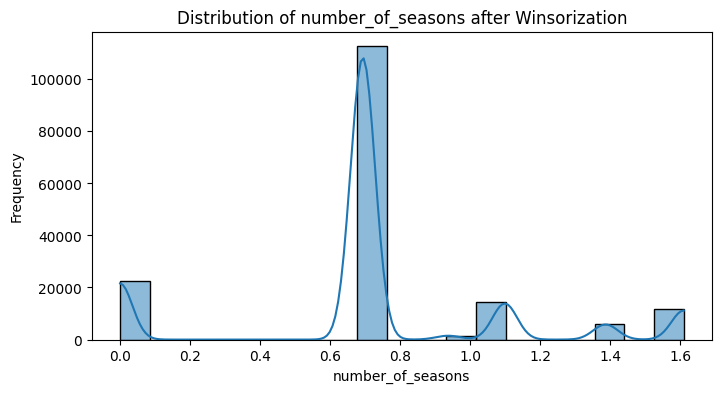

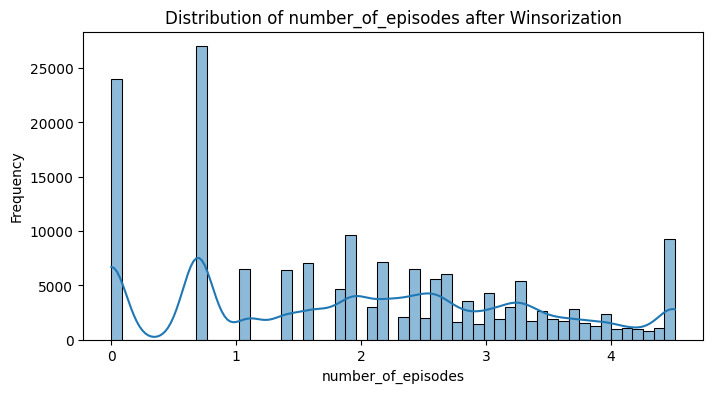

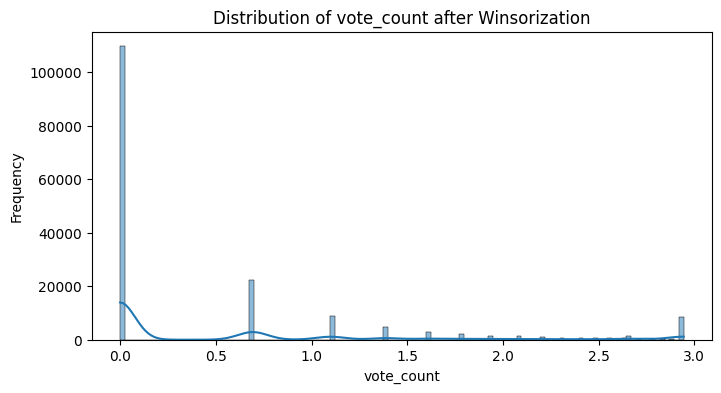

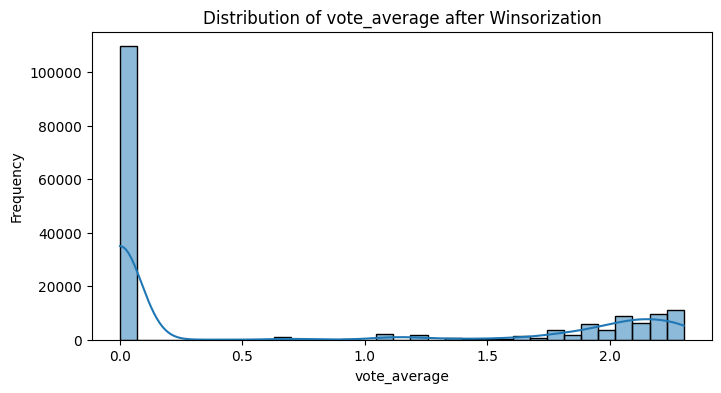

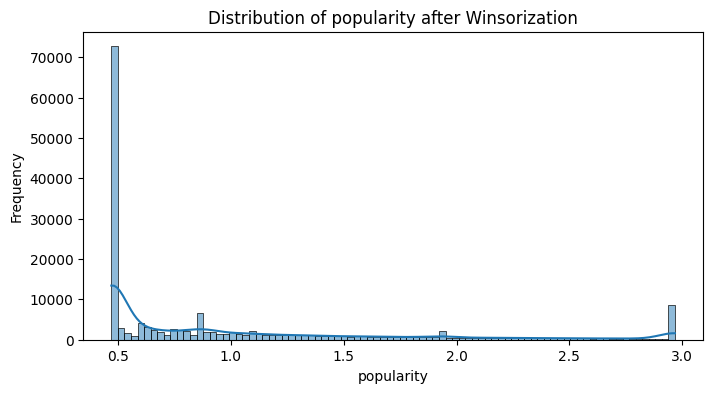

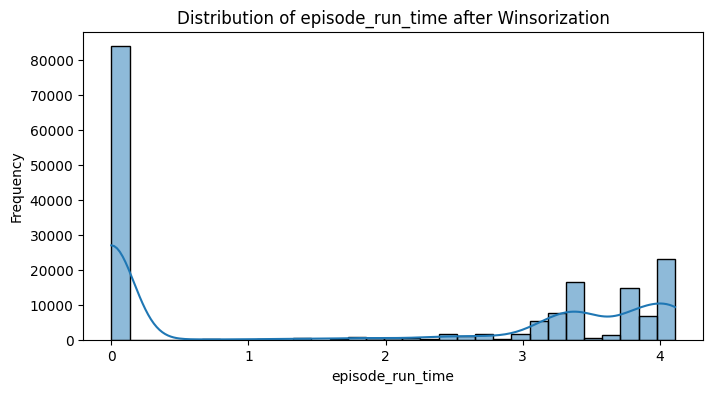

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms for each column in the winsorized DataFrame
for column in df_winsorized.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_winsorized[column], kde=True)
    plt.title(f'Distribution of {column} after Winsorization')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Normalization of Numerical Data


In [336]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
df

,id,name,number_of_seasons,number_of_episodes,vote_count,vote_average,overview,adult,backdrop_path,first_air_date,last_air_date,homepage,in_production,original_name,popularity,poster_path,tagline,languages,spoken_languages,production_countries,episode_run_time,vote_average_binned,Action & Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,History,Kids,Music,Musical,Mystery,News,Reality,Romance,Sci-Fi & Fantasy,Soap,Talk,Unknown,War & Politics,Western,original-language_en,original-language_zh,original-language_ja,original-language_ko,original-language_de,original-language_fr,original-language_es,original-language_pt,original-language_ru,original-language_nl,original-language_ar,original-language_da,original-language_cn,original-language_th,original-language_tr,original-language_it,original-language_hi,original-language_sv,original-language_cs,original-language_no,created-by_Shotaro Ishinomori,created-by_John de Mol,created-by_Adrián Suar,created-by_Simon Fuller,created-by_Ekta Kapoor,created-by_Na Young-seok,created-by_Yang Li-Hua,"created-by_Joseph Barbera, William Hanna",created-by_R.J. Nuevas,created-by_Mark Burnett,networks_BBC One,networks_YouTube,networks_Netflix,networks_ITV1,networks_BBC Two,networks_ABC,networks_NBC,networks_TVB Jade,networks_CBS,networks_Channel 4,networks_ZDF,origin-country_US,origin-country_JP,origin-country_GB,origin-country_CN,origin-country_DE,origin-country_KR,origin-country_CA,origin-country_FR,origin-country_AU,origin-country_BR,origin-country_NL,origin-country_RU,origin-country_ES,origin-country_TH,origin-country_HK,origin-country_IN,origin-country_DK,origin-country_PH,origin-country_IT,origin-country_TR,origin-country_SE,origin-country_NO,origin-country_TW,origin-country_BE,origin-country_CZ,origin-country_MX,production-companies_US,production-companies_JP,production-companies_GB,production-companies_CN,production-companies_DE,production-companies_KR,production-companies_CA,production-companies_FR,production-companies_AU,production-companies_BR,production-companies_NL,production-companies_RU,production-companies_ES,production-companies_TH,production-companies_HK,production-companies_IN,production-companies_DK,production-companies_PH,production-companies_IT,production-companies_TR,production-companies_SE,production-companies_NO,production-companies_TW,production-companies_BE,production-companies_CZ,production-companies_MX,type_Documentary,type_Miniseries,type_News,type_Reality,type_Scripted,type_Talk Show,type_Video,status_Canceled,status_Ended,status_In Production,status_Pilot,status_Planned,status_Returning Series,first_air_date_season,first_air_date_winter,first_air_date_spring,first_air_date_summer,first_air_date_fall,last_air_date_season,last_air_date_winter,last_air_date_spring,last_air_date_summer,last_air_date_fall,number_of_seasons_log,number_of_episodes_log,vote_count_log,vote_average_log,popularity_log,episode_run_time_log
0,0.005565,Game of Thrones,0.033333,0.003503,1.000000,0.844200,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,2019-05-19,http://www.hbo.com/game-of-thrones,False,Game of Thrones,0.292397,/1XS1oqL89opfnbLl8WnZY1O1uJx.jpg,Winter Is Coming,en,English,"United Kingdom, United States of America",0.000000,8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,False,False,True,False,False,False,False,SPRING,False,True,False,False,SPRING,False,True,False,False,0.400603,0.432803,1.000000,0.936308,0.850456,0.000000
1,0.284401,Money Heist,0.012500,0.001967,0.816031,0.825700,"To carry out

# Hypothesis: Predicting Popularity

In [337]:
from wordcloud import WordCloud

top_100_df = df.sort_values(by='popularity', ascending=False).head(100)
top_100_df_cleaned = top_100_df[top_100_df['cleaned_overview'].notna()]

text = ' '.join(top_100_df_cleaned['cleaned_overview'].astype(str))

STOPWORDS = []
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'show', 'series', 'television', 'episode', 'television series',
    'and', 'is', 'a', 'of', 'the', 'to', 'from', 'as', 'in', 'with', 'it', 'was', 'her', 'she', 'his', 'has', 'by', 'on', 'at', 'he', 'that',
    'an', 'who', 'its', 'after', 'program'
])

# Generate the word cloud for the top 50 shows
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=200, stopwords=custom_stopwords).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Overviews of Top 100 Most Popular TV Shows (Filtered)')
plt.show()

KeyError: 'cleaned_overview'

# Model Training

In [44]:
# Creating our labeled examples with 'y' as our label and 'X' being our features
y = df['popularity']
X = df.drop(columns = 'popularity', axis = 1)

We use train_test_split() because we want to split our data into training and test sets.

Train tests are used for fitting the model which means we train our model with this dataset.

Test sets are used to accurately evalute our final model's predicitions.

In [149]:
# Creating the training and test sets out of the labeled examples
# 30% of our data is for the test size, this will be the data used to test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1234)

Linear Regression

In [46]:
#• DISCLAIMER: Will indicate an error until we drop categorical columns
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

ValueError: could not convert string to float: 'Animals'

### Random Forest

In [338]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [339]:
# Adjust pandas display settings to show all columns
pd.set_option('display.max_columns', None)

# Now, when you print df.columns, it will show all columns
print(df.columns)

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'last_air_date_winter', 'last_air_date_spring', 'last_air_date_summer',
       'last_air_date_fall', 'number_of_seasons_log', 'number_of_episodes_log',
       'vote_count_log', 'vote_average_log', 'popularity_log',
       'episode_run_time_log'],
      dtype='object', length=165)


In [340]:
# Get column types
column_types = df.dtypes
print(column_types)

id                        float64
name                       object
number_of_seasons         float64
number_of_episodes        float64
vote_count                float64
                           ...   
number_of_episodes_log    float64
vote_count_log            float64
vote_average_log          float64
popularity_log            float64
episode_run_time_log      float64
Length: 165, dtype: object


In [341]:
# Get all numerical columns in the DataFrame
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

# Print the list of numerical columns
print(numerical_columns)

['id', 'number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time', 'Action & Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 'Mystery', 'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 'War & Politics', 'Western', 'original-language_en', 'original-language_zh', 'original-language_ja', 'original-language_ko', 'original-language_de', 'original-language_fr', 'original-language_es', 'original-language_pt', 'original-language_ru', 'original-language_nl', 'original-language_ar', 'original-language_da', 'original-language_cn', 'original-language_th', 'original-language_tr', 'original-language_it', 'original-language_hi', 'original-language_sv', 'original-language_cs', 'original-language_no', 'created-by_Shotaro Ishinomori', 'created-by_John de Mol', 'created-by_Adrián Suar', 'created-by_Simon Fuller', 'created-by_Ekta Kapoor', 'created-by_Na Young-seo

In [342]:
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'episode_run_time']]
y = df['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_mse = mean_squared_error(y_test, rf_predictions_test)
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_mse = mean_squared_error(y_train, rf_predictions_train)
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with regular dataset, 4 numerical features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')


Results with regular dataset, 4 numerical features:
Train MAE: 0.0007
Train MSE: 0.0000
Train R^2: 0.8101
Test MAE: 0.0014
Test MSE: 0.0001
Test R^2: 0.1258


In [343]:
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 'vote_average_log', 'episode_run_time']]
y = df['popularity_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_mse = mean_squared_error(y_test, rf_predictions_test)
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_mse = mean_squared_error(y_train, rf_predictions_train)
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Log Transformation, 4 features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

ValueError: Input y contains NaN.

In [256]:
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 
        'episode_run_time', 'Action & Adventure', 'Animation', 'Comedy', 'Crime', 
        'Documentary', 'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 
        'Mystery', 'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 
        'Talk', 'Unknown', 'War & Politics', 'Western']]
y = df['popularity_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_mse = mean_squared_error(y_test, rf_predictions_test)
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_mse = mean_squared_error(y_train, rf_predictions_train)
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Genres Features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Genres Features:
Train MAE: 0.0006
Train MSE: 0.0000
Train R^2: 0.8227
Test MAE: 0.0014
Test MSE: 0.0001
Test R^2: 0.1251


In [252]:
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 
        'vote_average_log', 'episode_run_time_log', 'Action & Adventure', 
        'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 
        'History', 'Kids', 'Music', 'Musical', 'Mystery', 'News', 'Reality', 
        'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 'War & Politics', 
        'Western', 'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_ar', 'original-language_da', 
        'original-language_cn', 'original-language_th', 'original-language_tr', 
        'original-language_it', 'original-language_hi', 'original-language_sv', 
        'original-language_cs', 'original-language_no', 'created-by_Shotaro Ishinomori', 
        'created-by_John de Mol', 'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 'created-by_Yang Li-Hua', 
        'created-by_Joseph Barbera, William Hanna', 'created-by_R.J. Nuevas', 
        'created-by_Mark Burnett', 'networks_BBC One', 'networks_YouTube', 
        'networks_Netflix', 'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 
        'networks_NBC', 'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_ZDF', 'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 'origin-country_CA', 
        'origin-country_FR', 'origin-country_AU', 'origin-country_BR', 'origin-country_NL', 
        'origin-country_RU', 'origin-country_ES', 'origin-country_TH', 'origin-country_HK', 
        'origin-country_IN', 'origin-country_DK', 'origin-country_PH', 'origin-country_IT', 
        'origin-country_TR', 'origin-country_SE', 'origin-country_NO', 'origin-country_TW', 
        'origin-country_BE', 'origin-country_CZ', 'origin-country_MX', 'production-companies_US', 
        'production-companies_JP', 'production-companies_GB', 'production-companies_CN', 
        'production-companies_DE', 'production-companies_KR', 'production-companies_CA', 
        'production-companies_FR', 'production-companies_AU', 'production-companies_BR', 
        'production-companies_NL', 'production-companies_RU', 'production-companies_ES', 
        'production-companies_TH', 'production-companies_HK', 'production-companies_IN', 
        'production-companies_DK', 'production-companies_PH', 'production-companies_IT', 
        'production-companies_TR', 'production-companies_SE', 'production-companies_NO', 
        'production-companies_TW', 'production-companies_BE', 'production-companies_CZ', 
        'production-companies_MX']]
y = df['popularity_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_mse = mean_squared_error(y_test, rf_predictions_test)
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_mse = mean_squared_error(y_train, rf_predictions_train)
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with One-Hot Encoded Features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')


Results with One-Hot Encoded Features:
Train MAE: 0.0005
Train MSE: 0.0000
Train R^2: 0.8932
Test MAE: 0.0013
Test MSE: 0.0001
Test R^2: 0.1809


In [118]:
print(df.columns)

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'first_air_date_season', 'first_air_date_winter',
       'first_air_date_spring', 'first_air_date_summer', 'first_air_date_fall',
       'last_air_date_season', 'last_air_date_winter', 'last_air_date_spring',
       'last_air_date_summer', 'last_air_date_fall'],
      dtype='object', length=159)


In [117]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average']
categorical_columns = ['original_language', 'created_by', 'networks', 'origin_country', 'production_companies']

X = df[numerical_columns + categorical_columns]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Standardize numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # One-hot encode categorical columns
    ],
    remainder='passthrough'
)

# Create a pipeline with the preprocessor and RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model on the training set
pipeline.fit(X_train, y_train)

# Predictions on train and test sets
rf_predictions_train = pipeline.predict(X_train)
rf_predictions_test = pipeline.predict(X_test)

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_mse = mean_squared_error(y_train, rf_predictions_train)
train_r2 = r2_score(y_train, rf_predictions_train)

test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_mse = mean_squared_error(y_test, rf_predictions_test)
test_r2 = r2_score(y_test, rf_predictions_test)

# Print results
print("Results with Log Transformation + One-Hot Encoded Features (after split):")
print(f'Train MAE: {train_mae:.4f}')
print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

KeyError: "['original_language', 'created_by', 'networks', 'origin_country', 'production_companies'] not in index"

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

X = df_log[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average']]
y = df_log['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_leaf=5, random_state=42)

rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_mse = mean_squared_error(y_test, rf_predictions_test)
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_mse = mean_squared_error(y_train, rf_predictions_train)
train_r2 = r2_score(y_train, rf_predictions_train)

# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')



Train MAE: 0.3781
Train MSE: 0.3440
Train R^2: 0.5729
Test MAE: 0.3756
Test MSE: 0.3413
Test R^2: 0.5668


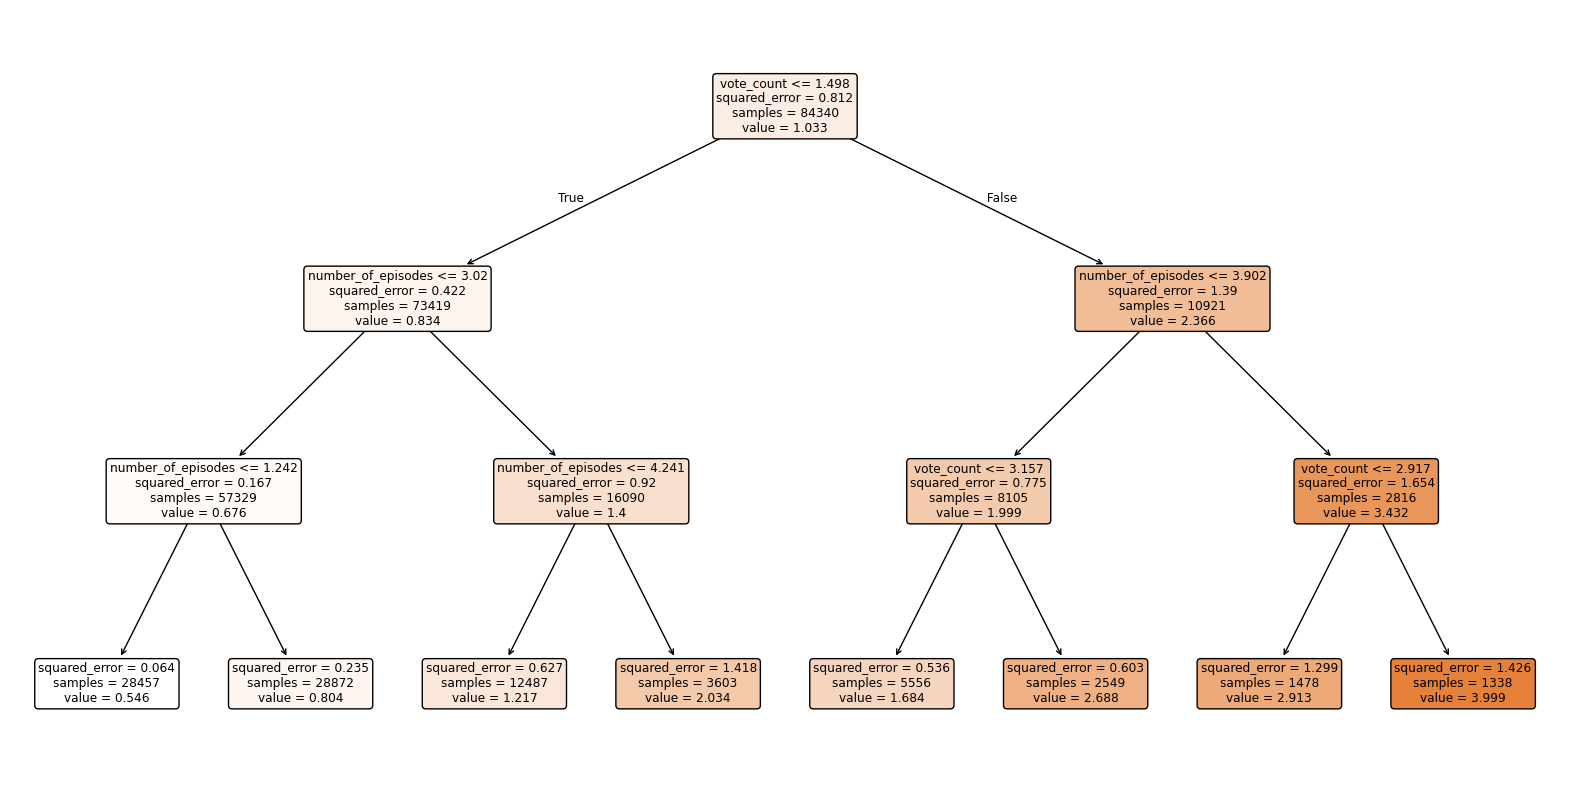

In [52]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Ensure interactive plotting in VS Code or notebooks
# %matplotlib inline  # Uncomment if in Jupyter
plt.ion()  # Interactive plotting in VS Code/Terminal

# Select the tree you want to visualize
tree_to_visualize = rf.estimators_[0]

# Plot the tree using plot_tree
plt.figure(figsize=(20, 10))  # Adjust figure size
plot_tree(tree_to_visualize, filled=True, feature_names=X.columns, rounded=True)

# Show the plot
plt.show()

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming 'df' is already defined and cleaned
# create X (features) and y (label)
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average']]
y = df['popularity']

# Split the data into training and testing sets BEFORE encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create the base RandomForestRegressor model with default parameters
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model to the training data
rf.fit(X_train, y_train)

# make predictions on the test data
rf_predictions = rf.predict(X_test)

# evaluate the model
mae = mean_absolute_error(y_test, rf_predictions)
mse = mean_squared_error(y_test, rf_predictions)
r2 = r2_score(y_test, rf_predictions)

# print evaluation metrics
print(f'Test MAE: {mae:.4f}')
print(f'Test MSE: {mse:.4f}')
print(f'Test R^2: {r2:.4f}')

Test MAE: 0.0013
Test MSE: 0.0001
Test R^2: 0.1722


In [55]:
"""
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Ensure interactive plotting in VS Code or notebooks
# %matplotlib inline  # Uncomment if in Jupyter
plt.ion()  # Interactive plotting in VS Code/Terminal

# Select the tree you want to visualize
tree_to_visualize = rf.estimators_[0]

# Plot the tree using plot_tree
plt.figure(figsize=(20, 10))  # Adjust figure size
plot_tree(tree_to_visualize, filled=True, feature_names=X.columns, rounded=True)

# Show the plot
plt.show()
"""

'\nimport matplotlib.pyplot as plt\nfrom sklearn.tree import plot_tree\n\n# Ensure interactive plotting in VS Code or notebooks\n# %matplotlib inline  # Uncomment if in Jupyter\nplt.ion()  # Interactive plotting in VS Code/Terminal\n\n# Select the tree you want to visualize\ntree_to_visualize = rf.estimators_[0]\n\n# Plot the tree using plot_tree\nplt.figure(figsize=(20, 10))  # Adjust figure size\nplot_tree(tree_to_visualize, filled=True, feature_names=X.columns, rounded=True)\n\n# Show the plot\nplt.show()\n'

An R² of 0.1348 means that about 13.48% of the variance in the popularity is explained by the model. This is a relatively low R² value, which suggests that while the model has low errors (as indicated by MAE and MSE), it may not be capturing a large portion of the variance in the data.

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Assume 'df' is your DataFrame
# create X (features) and y (label)
X = df[[col for col in df.columns if col not in ['popularity', 'cleaned_overview']]]  # ignoring 'cleaned_overview' for now
y = df['popularity']

# Split the data into training and testing sets (small test size for quick training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For simplicity, assuming the data doesn't need much preprocessing (i.e., no categorical encoding needed here)

# Simple RandomForestRegressor model with few trees and limited depth
rf = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
rf_predictions = rf.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, rf_predictions)
mse = mean_squared_error(y_test, rf_predictions)
r2 = r2_score(y_test, rf_predictions)

# Print the evaluation metrics
print(f'Test MAE: {mae:.4f}')
print(f'Test MSE: {mse:.4f}')
print(f'Test R^2: {r2:.4f}')

ValueError: could not convert string to float: 'Igor et Olafe'

In [9]:
# Check the number of columns
num_columns = X.shape[1]
print(f"Number of columns after one-hot encoding: {num_columns}")

Number of columns after one-hot encoding: 49
